# Loading data

In [2]:
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.helper_func_class as misc
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import scipy.stats
import os
import warnings

warnings.filterwarnings('ignore')
#import matplotlib.image as mpimg


"""

THE SUFFIXES IN THE VARIABLE NAMES

*** rt suffix -> relative target experiments
                 this means STATIC entrance,
                 since the target is always
                 positioned in the same spot
                 relative to the entrance
                 the mouse takes

*** ft suffix -> fixed target experiments
                 this means RANDOM entrance,
                 since the target is in a
                 different spot in every trial,
                 relative to the entrance the mouse
                 takes

*** 2t suffix -> two target experiments
                 mice are trained in two locations, consecutively

"""

mouse_traj_dir_ft = r'./experiments/fixed_target/mouse_*'
mouse_traj_dir_rt = r'./experiments/relative_target/mouse_*'
mouse_traj_dir_2t = r'./experiments/two_target_no_cues/mouse_*'

output_dir = 'figs/paper/geometry_random_vs_static'
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

color_rt = numpy.array((65, 102, 216, 255))/255
color_ft = numpy.array((224, 53, 53, 255))/255

SMALL_FONTSIZE  = 12
MEDIUM_FONTSIZE = 14
LARGE_FONTSIZE  = 16
plt.rc('font',        size=SMALL_FONTSIZE )  # controls default text sizes
plt.rc('axes',   titlesize=SMALL_FONTSIZE )  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_FONTSIZE) # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('legend',  fontsize=SMALL_FONTSIZE ) # legend fontsize
plt.rc('figure', titlesize=LARGE_FONTSIZE ) # fontsize of the figure title


FIGSIZE_1PANEL = numpy.array((4,3),dtype=float)
AX_POS_1PANEL  = numpy.array( [ 0.125, 0.125, 0.9, 0.88 ] ) # [xmin,ymin,width,heigh]
AX_POS_2PANELS = numpy.array([   AX_POS_1PANEL/2.0,
                               [ 1.5*AX_POS_1PANEL[0]+AX_POS_1PANEL[2]/2,AX_POS_1PANEL[1]/2,AX_POS_1PANEL[2]/2-0.5*AX_POS_1PANEL[0],AX_POS_1PANEL[3]/2 ] ])


# linear regression aux function
linreg_lin_func = lambda x,lr: lr.intercept + lr.slope * x
linreg_pl_func  = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)
linreg_exp_func = lambda x,lr: numpy.exp(lr.intercept + x*lr.slope)

# t-test aux function
p_significant = 0.05
q_FDR         = 0.05 # FDR-level for thresholding p_values correcting for false-discovery rate in multiple comparisons
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant


# loads experiment MAT files from file path according to the parameters
# all_trials_rt[k][m] -> trial k of mouse m
all_trials_rt,trial_labels_rt=io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True,skip_15_relative_target=True,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=True,align_to_top=True,group_by='trial',return_group_by_keys=True)
# all_trials_ft[k][m] -> trial k of mouse m
all_trials_ft,trial_labels_ft=io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True,skip_15_relative_target=False,use_extra_trials_relative_target=True,sort_by_trial=True,fix_nan=True,remove_after_food=True,align_to_top=True,group_by='trial',return_group_by_keys=True)
n_trials_ft = 14
n_trials_rt = 14
n_trials = numpy.min((n_trials_ft,n_trials_rt))



hole_horizon_rt_R180          = 5.0 # cm
get_hole_horiz_rt_R180        = lambda tr: hole_horizon_rt_R180 if int(tr.mouse_number) in [14,16] else None
all_trials_rt_R180            = io.load_trial_file(mouse_traj_dir_rt,file_name_expr='mpos_*_R180_1*',load_only_training_sessions_relative_target=False,skip_15_relative_target=True,use_extra_trials_relative_target=True,sort_by_trial=True,fix_nan=True,remove_after_food=False,group_by='none')#,max_trial_number=n_trials_to_use)
all_trials_rt_R180            = io.group_track_list([ tran.remove_path_after_food(tr,r_target=tr.r_target_reverse,return_t_to_food=False,force_main_target=False,hole_horizon=get_hole_horiz_rt_R180(tr),time_delay_after_food=0.0) for tr in all_trials_rt_R180 ],group_by='trial',return_group_keys=False)[0]
all_trials_rt_R180            = plib.rotate_trial_file(all_trials_rt_R180,(0,-1),return_only_track=True)


save_output_figures = True


# d_perp PERPENDICULAR DISTANCE TO THE FOOD LINE

PERPENDICULAR DISTANCE to food line

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = 2.80572     p = 0.018358021
     Random entrance (1 vs. 18)   :: T = -2.1001621     p = 0.055556323
 



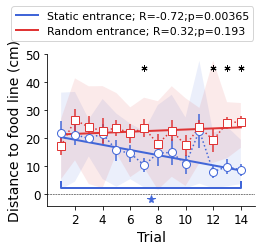

In [2]:
"""
###############
###############
###############
###############
############### d_perp PERPENDICULAR DISTANCE TO THE FOOD LINE
###############
###############
###############
###############
"""

# d == perpendicular distance to food line; first index -> trial, second index -> mouse
d_perp_rt = [ tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True) for all_mice in all_trials_rt ]
d_perp_ft = [ tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True) for all_mice in all_trials_ft ]

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
d_perp_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_perp_rt ] # axis=1 -> average over time (tmean)
#d_perp_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in d_perp_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
#d_perp_mmean_sd_err_rt = numpy.array(misc.mean_std_err_minmax(misc.zscore(misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_rt ]),axis=1),axis=1)).T # trial[0] -> mean of each mice
d_perp_mmean_sd_err_rt = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_rt ]),axis=1)).T # trial[0] -> mean of each mice

d_perp_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_perp_ft ] # axis=1 -> average over time (tmean)
#d_perp_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in d_perp_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
#d_perp_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(misc.zscore(misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_ft ]),axis=1),axis=1)).T # trial[0] -> mean of each mice
d_perp_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_ft ]),axis=1)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
d_perp_Z_rt,d_perp_Z_ft  = misc.zscore_to_control(  misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_rt[:n_trials] ]), misc.asarray_nanfill([ trial[0] for trial in d_perp_tmean_sd_err_ft[:n_trials] ])   , axis=1)
d_perp_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(d_perp_Z_rt,axis=1)).T
d_perp_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(d_perp_Z_ft,axis=1)).T

#######
####### calculating distributions
#######

n_bins = 25
P_d_perp_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_perp_rt ]
P_d_perp_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_perp_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func   = lambda x:x #numpy.log
linreg_func      = linreg_lin_func # linreg_exp_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

d_perp_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials_rt),     linearize_func(d_perp_mmean_sd_err_rt[:n_trials_rt,0]), alternative='two-sided')
d_perp_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials_ft),     linearize_func(d_perp_mmean_sd_err_ft[:n_trials_ft,0]), alternative='two-sided')
d_perp_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_perp_mmean_sd_err_Z_rt[:,0]         ), alternative='two-sided')
d_perp_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_perp_mmean_sd_err_Z_ft[:,0]         ), alternative='two-sided')

#######
####### t-test
#######

# comparing each trial of rt vs. ft
d_perp_ttest_trials  = scipy.stats.ttest_ind(d_perp_Z_rt,d_perp_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(d_perp_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
d_perp_ttest_first_last_rt = scipy.stats.ttest_ind(d_perp_tmean_sd_err_rt[0][0],d_perp_tmean_sd_err_rt[n_trials_rt-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')
d_perp_ttest_first_last_ft = scipy.stats.ttest_ind(d_perp_tmean_sd_err_ft[0][0],d_perp_tmean_sd_err_ft[n_trials_ft-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'PERPENDICULAR DISTANCE to food line\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials_rt})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_perp_ttest_first_last_rt.statistic,d_perp_ttest_first_last_rt.pvalue,'(*)' if check_significance(d_perp_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials_ft})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_perp_ttest_first_last_ft.statistic,d_perp_ttest_first_last_ft.pvalue,'(*)' if check_significance(d_perp_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######

fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_perp_mmean_sd_err_rt[:n_trials,0],[d_perp_mmean_sd_err_rt[:n_trials,-2],d_perp_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_perp_mmean_sd_err_ft[:n_trials,0],[d_perp_mmean_sd_err_ft[:n_trials,-2],d_perp_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_perp_mmean_sd_err_rt[:n_trials,0],d_perp_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1, d_perp_mmean_sd_err_ft[:n_trials,0],d_perp_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_perp_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.2g};p={1:.3g}'.format(d_perp_linreg_trial_rt.rvalue,d_perp_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_perp_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.2g};p={1:.3g}'.format(d_perp_linreg_trial_ft.rvalue,d_perp_linreg_trial_ft.pvalue))
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials)+1)[k_significant_trials], y0_asterisk*numpy.ones(n_trials)[k_significant_trials], markersize=6, marker=(6,2), linestyle='none', color='k' )
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1.05),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Distance to food line (cm)')

data_rt  = d_perp_mmean_sd_err_rt
data_ft  = d_perp_mmean_sd_err_ft
ttest_rt = d_perp_ttest_first_last_rt
ttest_ft = d_perp_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-numpy.min(data_rt[:n_trials,2]),
                            dy=None, TXT=None, color=color_rt, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+numpy.max(data_ft[:n_trials,2]),
                            dy=None, TXT=None, color=color_ft, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))


pltt.set_box_axis(ax,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_trials_perp_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_vs_random_trials_perp_dist_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

# ha_cos HEADING ANGLE (AND COSINE)

HEADING ANGLE between mouse and food-mouse vector

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = -4.0935168     p = 0.0017249839
     Random entrance (1 vs. 18)   :: T = -1.2025562     p = 0.24914512
 



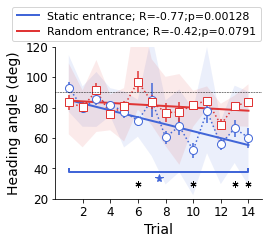

In [3]:
"""
###############
###############
###############
###############
############### ha_cos HEADING ANGLE (AND COSINE)
###############
###############
###############
###############
"""

# ha == heading angle of mice relative to mouse-food vector
ha_cos_rt = [ tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False) for all_mice in all_trials_rt ]
ha_cos_ft = [ tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False) for all_mice in all_trials_ft ]

#######
####### calculating time and mouse averages (convert from cosine to angle only when taking the last average to have the correct result, otherwise angles such as pi and 0 will be averaged wrongly)
#######

# each item in the list below containes the average d for each mice
ha_cos_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in ha_cos_rt ] # axis=1 -> average over time (tmean)
#ha_cos_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in ha_cos_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
ha_cos_mmean_sd_err_rt = numpy.array(misc.avg_angle_from_cos(misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_rt ]),axis=1,return_minmax=True)).T # trial[0] -> mean of each mice

ha_cos_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in ha_cos_ft ] # axis=1 -> average over time (tmean)
#ha_cos_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in ha_cos_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
ha_cos_mmean_sd_err_ft = numpy.array(misc.avg_angle_from_cos(misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_ft ]),axis=1,return_minmax=True)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
ha_cos_Z_rt,ha_cos_Z_ft  = misc.zscore_to_control(  numpy.arccos(misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_rt[:n_trials] ])), numpy.arccos(misc.asarray_nanfill([ trial[0] for trial in ha_cos_tmean_sd_err_ft[:n_trials] ]))   , axis=1)
ha_cos_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(ha_cos_Z_rt,axis=1)).T
ha_cos_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(ha_cos_Z_ft,axis=1)).T

#######
####### calculating distributions
#######

n_bins = 25
P_ha_cos_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in ha_cos_rt ]
P_ha_cos_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in ha_cos_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func = lambda x:x #numpy.log
linreg_func    = linreg_lin_func #linreg_exp_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

ha_cos_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials_rt),   linearize_func(ha_cos_mmean_sd_err_rt[:n_trials_rt,0]), alternative='two-sided')
ha_cos_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials_ft),   linearize_func(ha_cos_mmean_sd_err_ft[:n_trials_ft,0]), alternative='two-sided')
ha_cos_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials)   , linearize_func_Z(ha_cos_mmean_sd_err_Z_rt[:,0]         ), alternative='two-sided')
ha_cos_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials)   , linearize_func_Z(ha_cos_mmean_sd_err_Z_ft[:,0]         ), alternative='two-sided')

#######
####### t-test
#######

# comparing each trial of rt vs. ft
ha_cos_ttest_trials  = scipy.stats.ttest_ind(ha_cos_Z_rt,ha_cos_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(ha_cos_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
ha_cos_ttest_first_last_rt = scipy.stats.ttest_ind(ha_cos_tmean_sd_err_rt[0][0],ha_cos_tmean_sd_err_rt[n_trials_rt-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')
ha_cos_ttest_first_last_ft = scipy.stats.ttest_ind(ha_cos_tmean_sd_err_ft[0][0],ha_cos_tmean_sd_err_ft[n_trials_ft-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'HEADING ANGLE between mouse and food-mouse vector\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials_rt})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(ha_cos_ttest_first_last_rt.statistic,ha_cos_ttest_first_last_rt.pvalue,'(*)' if check_significance(ha_cos_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials_ft})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(ha_cos_ttest_first_last_ft.statistic,ha_cos_ttest_first_last_ft.pvalue,'(*)' if check_significance(ha_cos_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,ha_cos_mmean_sd_err_rt[:n_trials,0],[ha_cos_mmean_sd_err_rt[:n_trials,-2],ha_cos_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,ha_cos_mmean_sd_err_ft[:n_trials,0],[ha_cos_mmean_sd_err_ft[:n_trials,-2],ha_cos_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, ha_cos_mmean_sd_err_rt[:n_trials,0],ha_cos_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1, ha_cos_mmean_sd_err_ft[:n_trials,0],ha_cos_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,ha_cos_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.2g};p={1:.3g}'.format(ha_cos_linreg_trial_rt.rvalue,ha_cos_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,ha_cos_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.2g};p={1:.3g}'.format(ha_cos_linreg_trial_ft.rvalue,ha_cos_linreg_trial_ft.pvalue))
pltt.plot_horizontal_lines(90,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-1,xMax=20)
y0_asterisk = ax.get_ylim()[0] + 0.1*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials)+1)[k_significant_trials], y0_asterisk*numpy.ones(n_trials)[k_significant_trials], markersize=6, marker=(6,2), linestyle='none', color='k' )
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(20,120)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Heading angle (deg)')


data_rt  = ha_cos_mmean_sd_err_rt
data_ft  = ha_cos_mmean_sd_err_ft
ttest_rt = ha_cos_ttest_first_last_rt
ttest_ft = ha_cos_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-4*numpy.min(data_rt[:n_trials,2]),
                            dy=None, TXT=None, color=color_rt, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+4*numpy.max(data_ft[:n_trials,2]),
                            dy=None, TXT=None, color=color_ft, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))


pltt.set_box_axis(ax,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_trials_head_angle.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_vs_random_trials_head_angle_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

# d_food TOTAL DISTANCE TO GET TO THE FOOD

TOTAL DISTANCE TO FOOD for each mouse

 *** Trial values

     Static entrance (1 vs. 14)
          first trial: m+-SD = 1466.6172 +- 921.0025 cm
           last trial: m+-SD = 114.20638 +- 41.004558 cm
     Random entrance (1 vs. 14)
          first trial: m+-SD = 796.88272 +- 684.92928 cm
           last trial: m+-SD = 918.8443 +- 523.28431 cm

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = 3.8812073     p = 0.0059972724
     Random entrance (1 vs. 14)   :: T = -0.37436128     p = 0.71412761
 

*** saving ...  figs/paper/geometry_random_vs_static/stat_vs_random_trials_d_food.png
*** saving ...  figs/paper/geometry_random_vs_static/stat_vs_random_trials_d_food_ttest.txt
*** saving ...  figs/paper/geometry_random_vs_static/static_trials_d_food.png
*** saving ...  figs/paper/geometry_random_vs_static/random_trials_d_food.png


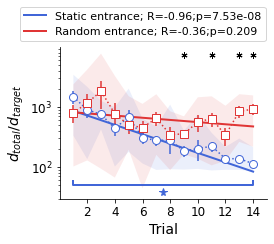

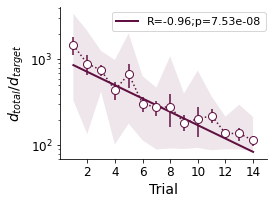

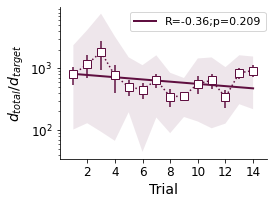

In [20]:
"""
###############
###############
###############
###############
############### d_food TOTAL DISTANCE TO GET TO THE FOOD
###############
###############
###############
###############
"""

# d_food == time to get to the food
d_food_rt = [ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_rt ]
d_food_ft = [ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ]

d_food_baseline = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
#d_food_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_food_rt ] # axis=1 -> average over time (tmean)
#d_food_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in d_food_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
d_food_mmean_sd_err_rt = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_rt),axis=1)).T # trial[0] -> mean of each mice

#d_food_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_food_ft ] # axis=1 -> average over time (tmean)
#d_food_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in d_food_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
d_food_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(d_food_ft),axis=1)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
d_food_Z_rt,d_food_Z_ft  = misc.zscore_to_control(  misc.asarray_nanfill(d_food_rt)[:n_trials,:], misc.asarray_nanfill(d_food_ft)[:n_trials,:]   , axis=1)
d_food_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(d_food_Z_rt,axis=1)).T
d_food_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(d_food_Z_ft,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_d_food_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_food_rt ]
P_d_food_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_food_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func   = numpy.log  # lambda x:x
linreg_func      = linreg_exp_func # linreg_lin_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

d_food_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  d_food_mmean_sd_err_rt[:n_trials,0]), alternative='two-sided')
d_food_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  d_food_mmean_sd_err_ft[:n_trials,0]), alternative='two-sided')
d_food_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(d_food_mmean_sd_err_Z_rt[:        ,0]), alternative='two-sided')
d_food_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(d_food_mmean_sd_err_Z_ft[:        ,0]), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
d_food_ttest_trials  = scipy.stats.ttest_ind(d_food_Z_rt,d_food_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(d_food_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
d_food_ttest_first_last_rt = scipy.stats.ttest_ind(d_food_rt[0],d_food_rt[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')
d_food_ttest_first_last_ft = scipy.stats.ttest_ind(d_food_ft[0],d_food_ft[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'TOTAL DISTANCE TO FOOD for each mouse\n\n'
ttest_result += ' *** Trial values' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {d_food_mmean_sd_err_rt[         0,0]:.8g} +- {d_food_mmean_sd_err_rt[         0,1]:.8g} cm\n'
ttest_result += f'           last trial: m+-SD = {d_food_mmean_sd_err_rt[n_trials-1,0]:.8g} +- {d_food_mmean_sd_err_rt[n_trials-1,1]:.8g} cm\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {d_food_mmean_sd_err_ft[         0,0]:.8g} +- {d_food_mmean_sd_err_ft[         0,1]:.8g} cm\n'
ttest_result += f'           last trial: m+-SD = {d_food_mmean_sd_err_ft[n_trials-1,0]:.8g} +- {d_food_mmean_sd_err_ft[n_trials-1,1]:.8g} cm\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_food_ttest_first_last_rt.statistic,d_food_ttest_first_last_rt.pvalue,'(*)' if check_significance(d_food_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_food_ttest_first_last_ft.statistic,d_food_ttest_first_last_ft.pvalue,'(*)' if check_significance(d_food_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_rt[:n_trials,0],[d_food_mmean_sd_err_rt[:n_trials,-2],d_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_ft[:n_trials,0],[d_food_mmean_sd_err_ft[:n_trials,-2],d_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_rt[:n_trials,0],d_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_ft[:n_trials,0],d_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_rt.rvalue,d_food_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_ft.rvalue,d_food_linreg_trial_ft.pvalue))
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials)+1)[k_significant_trials], y0_asterisk*numpy.ones(n_trials)[k_significant_trials], markersize=6, marker=(6,2), linestyle='none', color='k' )
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')

data_rt  = d_food_mmean_sd_err_rt
data_ft  = d_food_mmean_sd_err_ft
ttest_rt = d_food_ttest_first_last_rt
ttest_ft = d_food_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-3*numpy.min(data_rt[:n_trials,2]),
                            dy=None, TXT=None, color=color_rt, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+3*numpy.max(data_ft[:n_trials,2]),
                            dy=None, TXT=None, color=color_ft, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))

pltt.set_box_axis(ax,False)

if save_output_figures:
    fig_name  = f'{output_dir}/stat_vs_random_trials_d_food.png'
    txtf_name = f'{output_dir}/stat_vs_random_trials_d_food_ttest.txt'
    print('*** saving ... ',fig_name )
    print('*** saving ... ',txtf_name)
    plt.savefig(  fig_name ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(txtf_name,numpy.array([[]]),header=ttest_result)



color_purple_kelly = '#5F0F40'
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_rt[:n_trials,0],[d_food_mmean_sd_err_rt[:n_trials,-2],d_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_purple_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_rt[:n_trials,0],d_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_purple_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_rt),'-',color=color_purple_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_rt.rvalue,d_food_linreg_trial_rt.pvalue))
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
#ax.set_ylim(0.9,50)
ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    fig_name =   f'{output_dir}/static_trials_d_food.png'
    print('*** saving ... ',fig_name )
    plt.savefig(fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_ft[:n_trials,0],[d_food_mmean_sd_err_ft[:n_trials,-2],d_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_purple_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_ft[:n_trials,0],d_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_purple_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_ft),'-',color=color_purple_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_ft.rvalue,d_food_linreg_trial_ft.pvalue))
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
#ax.set_ylim(0.9,50)
ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    fig_name =  f'{output_dir}/random_trials_d_food.png'
    print('*** saving ... ',fig_name )
    plt.savefig( fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

# d/dtarget - normalized distance

NORMALIZED DISTANCE TO FOOD for each mouse

 *** Trial values

     Static entrance (1 vs. 14)
          first trial: m+-SD = 18.023643 +- 11.359372
           last trial: m+-SD = 1.4024748 +- 0.50214066
     Random entrance (1 vs. 14)
          first trial: m+-SD = 11.486621 +- 8.2539085
           last trial: m+-SD = 15.507363 +- 9.9222529
     180deg ROTATED Static entrance (1 vs. 14)
                trial: m+-SD = 1.9601377 +- 0.89669405

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = 3.867518     p = 0.0061052285
     Random entrance (1 vs. 14)   :: T = -0.824226     p = 0.42408177
 

*** saving ...  figs/paper/geometry_random_vs_static/stat_vs_random_trials_dnorm.png
*** saving ...  figs/paper/geometry_random_vs_static/stat_vs_random_trials_dnorm_ttest.txt
*** saving ...  figs/paper/geometry_random_vs_static/static_trials_dnorm.png
*** saving ...  figs/paper/geometry_random_vs_static/random_trials_dnorm.png


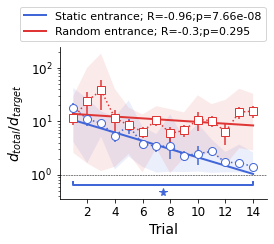

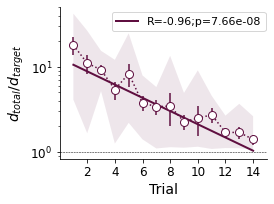

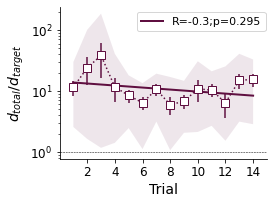

In [26]:
"""
###############
###############
###############
###############
############### d_food TOTAL DISTANCE TO GET TO THE FOOD
###############
###############
###############
###############
"""

# d_food == time to get to the food
d_food_rt      = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice)             for all_mice in all_trials_rt ])
d_food_rt_R180 =                        tran.calc_traveled_dist(all_trials_rt_R180)
d_food_ft      = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice)             for all_mice in all_trials_ft ])



calc_d_target = lambda track,tgt_label='r_target': numpy.linalg.norm(track[tgt_label]-track.r_start)

# static entrance has always the same distance from start to target
d_target_rt      = misc.asarray_nanfill([[calc_d_target(tr) for tr in all_mice] for all_mice in all_trials_rt])
d_target_rt_R180 = numpy.array([ calc_d_target(tr,'r_target_reverse') for tr in all_trials_rt_R180 ])

# random entrance has varying distance from start to target due to changing entrance
d_target_ft = misc.asarray_nanfill([[calc_d_target(tr) for tr in all_mice] for all_mice in all_trials_ft])


d_food_rt      = d_food_rt      / d_target_rt
d_food_rt_R180 = d_food_rt_R180 / d_target_rt_R180
d_food_ft      = d_food_ft      / d_target_ft

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
#d_food_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_food_rt ] # axis=1 -> average over time (tmean)
#d_food_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in d_food_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
d_food_mmean_sd_err_rt      = numpy.array(misc.mean_std_err_minmax(d_food_rt,axis=1)).T # trial[0] -> mean of each mice
d_food_mmean_sd_err_rt_R180 = misc.mean_std_err_minmax(d_food_rt_R180) # trial[0] -> mean of each mice

#d_food_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_food_ft ] # axis=1 -> average over time (tmean)
#d_food_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in d_food_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
d_food_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(d_food_ft,axis=1)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
d_food_Z_rt,d_food_Z_ft  = misc.zscore_to_control(  d_food_rt[:n_trials,:], d_food_ft[:n_trials,:]   , axis=1)
d_food_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(d_food_Z_rt,axis=1)).T
d_food_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(d_food_Z_ft,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_d_food_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_food_rt ]
P_d_food_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_food_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func   = numpy.log  # lambda x:x
linreg_func      = linreg_exp_func # linreg_lin_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

d_food_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  d_food_mmean_sd_err_rt[:n_trials,0]), alternative='two-sided')
d_food_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  d_food_mmean_sd_err_ft[:n_trials,0]), alternative='two-sided')
d_food_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(d_food_mmean_sd_err_Z_rt[:        ,0]), alternative='two-sided')
d_food_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(d_food_mmean_sd_err_Z_ft[:        ,0]), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
d_food_ttest_trials  = scipy.stats.ttest_ind(d_food_Z_rt,d_food_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(d_food_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
d_food_ttest_first_last_rt = scipy.stats.ttest_ind(d_food_rt[0],d_food_rt[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')
d_food_ttest_first_last_ft = scipy.stats.ttest_ind(d_food_ft[0],d_food_ft[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'NORMALIZED DISTANCE TO FOOD for each mouse\n\n'
ttest_result += ' *** Trial values' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {d_food_mmean_sd_err_rt[         0,0]:.8g} +- {d_food_mmean_sd_err_rt[         0,1]:.8g}\n'
ttest_result += f'           last trial: m+-SD = {d_food_mmean_sd_err_rt[n_trials-1,0]:.8g} +- {d_food_mmean_sd_err_rt[n_trials-1,1]:.8g}\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {d_food_mmean_sd_err_ft[         0,0]:.8g} +- {d_food_mmean_sd_err_ft[         0,1]:.8g}\n'
ttest_result += f'           last trial: m+-SD = {d_food_mmean_sd_err_ft[n_trials-1,0]:.8g} +- {d_food_mmean_sd_err_ft[n_trials-1,1]:.8g}\n'
ttest_result += f'     180deg ROTATED Static entrance (1 vs. {n_trials})\n'
ttest_result += f'                trial: m+-SD = {d_food_mmean_sd_err_rt_R180[0]:.8g} +- {d_food_mmean_sd_err_rt_R180[1]:.8g}\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_food_ttest_first_last_rt.statistic,d_food_ttest_first_last_rt.pvalue,'(*)' if check_significance(d_food_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_food_ttest_first_last_ft.statistic,d_food_ttest_first_last_ft.pvalue,'(*)' if check_significance(d_food_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_rt[:n_trials,0],[d_food_mmean_sd_err_rt[:n_trials,-2],d_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_ft[:n_trials,0],[d_food_mmean_sd_err_ft[:n_trials,-2],d_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_rt[:n_trials,0],d_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_ft[:n_trials,0],d_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_rt.rvalue,d_food_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_ft.rvalue,d_food_linreg_trial_ft.pvalue))
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials)+1)[k_significant_trials], y0_asterisk*numpy.ones(n_trials)[k_significant_trials], markersize=6, marker=(6,2), linestyle='none', color='k' )
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')

data_rt  = d_food_mmean_sd_err_rt
data_ft  = d_food_mmean_sd_err_ft
ttest_rt = d_food_ttest_first_last_rt
ttest_ft = d_food_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-3*numpy.min(data_rt[:n_trials,2]),
                            dy=None, TXT=None, color=color_rt, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+3*numpy.max(data_ft[:n_trials,2]),
                            dy=None, TXT=None, color=color_ft, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))

pltt.set_box_axis(ax,False)

if save_output_figures:
    fig_name  = f'{output_dir}/stat_vs_random_trials_dnorm.png'      
    txtf_name = f'{output_dir}/stat_vs_random_trials_dnorm_ttest.txt'
    print('*** saving ... ',fig_name )
    print('*** saving ... ',txtf_name)
    plt.savefig(  fig_name  ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(txtf_name ,numpy.array([[]]),header=ttest_result)



color_purple_kelly = '#5F0F40'
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_rt[:n_trials,0],[d_food_mmean_sd_err_rt[:n_trials,-2],d_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_purple_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_rt[:n_trials,0],d_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_purple_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_rt),'-',color=color_purple_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_rt.rvalue,d_food_linreg_trial_rt.pvalue))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
#ax.set_ylim(0.9,50)
ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    fig_name  = f'{output_dir}/static_trials_dnorm.png'
    print('*** saving ... ',fig_name )
    plt.savefig( fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_food_mmean_sd_err_ft[:n_trials,0],[d_food_mmean_sd_err_ft[:n_trials,-2],d_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_purple_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, d_food_mmean_sd_err_ft[:n_trials,0],d_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_purple_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_food_linreg_trial_ft),'-',color=color_purple_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(d_food_linreg_trial_ft.rvalue,d_food_linreg_trial_ft.pvalue))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
#ax.set_ylim(0.9,50)
ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{total}/d_{target}$')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    fig_name  = f'{output_dir}/random_trials_dnorm.png'
    print('*** saving ... ',fig_name )
    plt.savefig( fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

# vel VELOCITY

VELOCITY for each mouse

 *** Trial values

     Static entrance (1 vs. 14)
          first trial: m+-SD = 6.0415736 +- 2.4803619 cm/s
           last trial: m+-SD = 17.251646 +- 4.6374486 cm/s
     Random entrance (1 vs. 14)
          first trial: m+-SD = 6.6813266 +- 3.789029 cm/s
           last trial: m+-SD = 11.398262 +- 5.0695518 cm/s
     180deg ROTATED Static entrance (1 vs. 14)
                trial: m+-SD = 14.601769 +- 5.212377 cm/s

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = -5.6395709     p = 0.00016746474
     Random entrance (1 vs. 14)   :: T = -1.9718289     p = 0.07035825
 



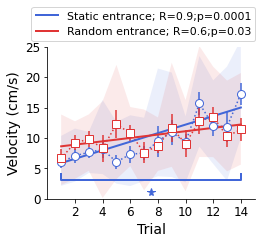

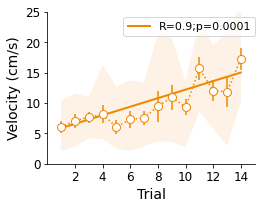

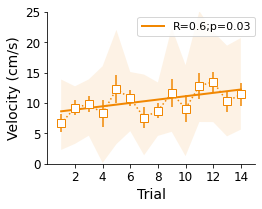

In [30]:
"""
###############
###############
###############
###############
############### vel VELOCITY
###############
###############
###############
###############
"""

# vel == time to get to the food
vel_rt      = misc.asarray_nanfill([ [ misc.nanmean(tr.velocity) for tr in all_mice           ] for all_mice in all_trials_rt ])
vel_rt_R180 =          numpy.array(  [ misc.nanmean(tr.velocity) for tr in all_trials_rt_R180 ])
vel_ft      = misc.asarray_nanfill([ [ misc.nanmean(tr.velocity) for tr in all_mice           ] for all_mice in all_trials_ft ])

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
#vel_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in vel_rt ] # axis=1 -> average over time (tmean)
#vel_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in vel_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
vel_mmean_sd_err_rt      = numpy.array(misc.mean_std_err_minmax(vel_rt,axis=1)).T # trial[0] -> mean of each mice
vel_mmean_sd_err_rt_R180 = misc.mean_std_err_minmax(vel_rt_R180) # trial[0] -> mean of each mice

#vel_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in vel_ft ] # axis=1 -> average over time (tmean)
#vel_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in vel_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
vel_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(vel_ft,axis=1)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
vel_Z_rt,vel_Z_ft  = misc.zscore_to_control(  vel_rt[:n_trials,:], vel_ft[:n_trials,:]   , axis=1)
vel_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(vel_Z_rt,axis=1)).T
vel_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(vel_Z_ft,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_vel_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in vel_rt ]
P_vel_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in vel_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func   =  lambda x:x #numpy.log  #
linreg_func      =  linreg_lin_func # linreg_exp_func #
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

vel_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  vel_mmean_sd_err_rt[:n_trials,0]), alternative='two-sided')
vel_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials) ,   linearize_func(  vel_mmean_sd_err_ft[:n_trials,0]), alternative='two-sided')
vel_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(vel_mmean_sd_err_Z_rt[:        ,0]), alternative='two-sided')
vel_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials) , linearize_func_Z(vel_mmean_sd_err_Z_ft[:        ,0]), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
vel_ttest_trials  = scipy.stats.ttest_ind(vel_Z_rt,vel_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(vel_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
vel_ttest_first_last_rt = scipy.stats.ttest_ind(vel_rt[0],vel_rt[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')
vel_ttest_first_last_ft = scipy.stats.ttest_ind(vel_ft[0],vel_ft[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'VELOCITY for each mouse\n\n'
ttest_result += ' *** Trial values' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {vel_mmean_sd_err_rt[         0,0]:.8g} +- {vel_mmean_sd_err_rt[         0,1]:.8g} cm/s\n'
ttest_result += f'           last trial: m+-SD = {vel_mmean_sd_err_rt[n_trials-1,0]:.8g} +- {vel_mmean_sd_err_rt[n_trials-1,1]:.8g} cm/s\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {vel_mmean_sd_err_ft[         0,0]:.8g} +- {vel_mmean_sd_err_ft[         0,1]:.8g} cm/s\n'
ttest_result += f'           last trial: m+-SD = {vel_mmean_sd_err_ft[n_trials-1,0]:.8g} +- {vel_mmean_sd_err_ft[n_trials-1,1]:.8g} cm/s\n'
ttest_result += f'     180deg ROTATED Static entrance (1 vs. {n_trials})\n'
ttest_result += f'                trial: m+-SD = {vel_mmean_sd_err_rt_R180[0]:.8g} +- {vel_mmean_sd_err_rt_R180[1]:.8g} cm/s\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(vel_ttest_first_last_rt.statistic,vel_ttest_first_last_rt.pvalue,'(*)' if check_significance(vel_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(vel_ttest_first_last_ft.statistic,vel_ttest_first_last_ft.pvalue,'(*)' if check_significance(vel_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
#fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
#
#ax.set_position([0.05,0.2,0.5,0.3])

fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,vel_mmean_sd_err_rt[:n_trials,0],[vel_mmean_sd_err_rt[:n_trials,-2],vel_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,vel_mmean_sd_err_ft[:n_trials,0],[vel_mmean_sd_err_ft[:n_trials,-2],vel_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,    vel_mmean_sd_err_rt[:n_trials,0],vel_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1,    vel_mmean_sd_err_ft[:n_trials,0],vel_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,vel_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.1g};p={1:.1g}'.format(vel_linreg_trial_rt.rvalue,vel_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,vel_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.1g};p={1:.1g}'.format(vel_linreg_trial_ft.rvalue,vel_linreg_trial_ft.pvalue))
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(0,25)
ax.legend(loc='lower right', bbox_to_anchor=(1.03, 1),prop=dict(size=11))
ax.set_xlabel('Trial'          )
ax.set_ylabel('Velocity (cm/s)')
ax.tick_params(axis='both',which='major')#,labelsize=11)


data_rt  = vel_mmean_sd_err_rt
data_ft  = vel_mmean_sd_err_ft
ttest_rt = vel_ttest_first_last_rt
ttest_ft = vel_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-numpy.min(data_rt[:n_trials,2]),
                            dy=1, TXT=None, color=color_rt, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+0.5*numpy.max(data_ft[:n_trials,2]),
                            dy=1, TXT=None, color=color_ft, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))


pltt.set_box_axis(ax,False)


if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_trials_vel.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_vs_random_trials_vel_ttest.txt',numpy.array([[]]),header=ttest_result)





color_orange_kelly = '#F18701'

fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))

pltt.plot_errorfill(numpy.arange(n_trials)+1,vel_mmean_sd_err_rt[:n_trials,0],[vel_mmean_sd_err_rt[:n_trials,-2],vel_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_orange_kelly,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,    vel_mmean_sd_err_rt[:n_trials,0],vel_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_orange_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,vel_linreg_trial_rt),'-',color=color_orange_kelly,linewidth=2,label='R={0:.1g};p={1:.1g}'.format(vel_linreg_trial_rt.rvalue,vel_linreg_trial_rt.pvalue))
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(0,25)
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1),prop=dict(size=11))
ax.set_xlabel('Trial'          )
ax.set_ylabel('Velocity (cm/s)')
ax.tick_params(axis='both',which='major')#,labelsize=11)
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/static_trials_velocity.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')



fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))

pltt.plot_errorfill(numpy.arange(n_trials)+1,vel_mmean_sd_err_ft[:n_trials,0],[vel_mmean_sd_err_ft[:n_trials,-2],vel_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_orange_kelly,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,    vel_mmean_sd_err_ft[:n_trials,0],vel_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_orange_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,vel_linreg_trial_ft),'-',color=color_orange_kelly,linewidth=2,label='R={0:.1g};p={1:.1g}'.format(vel_linreg_trial_ft.rvalue,vel_linreg_trial_ft.pvalue))
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(0,25)
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1),prop=dict(size=11))
ax.set_xlabel('Trial'          )
ax.set_ylabel('Velocity (cm/s)')
ax.tick_params(axis='both',which='major')#,labelsize=11)
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/random_trials_velocity.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# t_food TIME TO FOOD

TOTAL TIME TO FOOD for each mouse

 *** Trial values

     Static entrance (1 vs. 14)
          first trial: m+-SD = 255.38675 +- 153.2761 s
           last trial: m+-SD = 7.3785 +- 4.0285305 s
     Random entrance (1 vs. 14)
          first trial: m+-SD = 151.33738 +- 148.90598 s
           last trial: m+-SD = 80.379 +- 43.856767 s
     180deg ROTATED Static entrance (1 vs. 14)
                trial: m+-SD = 4.8035 +- 3.0591151 s

 *** T-Test between first and last trials

     Static entrance (1 vs. 14)(*):: T = 4.2794775     p = 0.0036461292
     Random entrance (1 vs. 14)   :: T = 1.2094183     p = 0.26019285
 



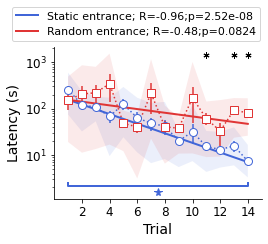

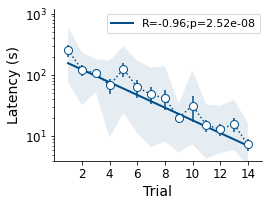

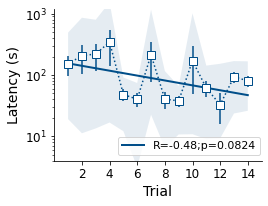

In [31]:
"""
###############
###############
###############
###############
############### t_food TOTAL DISTANCE TO GET TO THE FOOD
###############
###############
###############
###############
"""

# t_food == time to get to the food
t_food_rt      = misc.asarray_nanfill([ tran.calc_time_to_food(all_mice) for all_mice in all_trials_rt ])
t_food_rt_R180 =   tran.calc_time_to_food(all_trials_rt_R180)
t_food_ft      = misc.asarray_nanfill([ tran.calc_time_to_food(all_mice) for all_mice in all_trials_ft ])

t_food_baseline = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
#t_food_tmean_sd_err_rt = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in t_food_rt ] # axis=1 -> average over time (tmean)
#t_food_mmean_sd_err_rt = numpy.array([ misc.avg_of_avg(*trial) for trial in t_food_tmean_sd_err_rt ]) # col1 -> mean; col2 -> sd, col3 -> se
t_food_mmean_sd_err_rt      = numpy.array(misc.mean_std_err_minmax(t_food_rt,axis=1)).T # trial[0] -> mean of each mice
t_food_mmean_sd_err_rt_R180 = misc.mean_std_err_minmax(t_food_rt_R180) # trial[0] -> mean of each mice

#t_food_tmean_sd_err_ft = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in t_food_ft ] # axis=1 -> average over time (tmean)
#t_food_mmean_sd_err_ft = numpy.array([ misc.avg_of_avg(*trial) for trial in t_food_tmean_sd_err_ft ]) # col1 -> mean; col2 -> sd, col3 -> se
t_food_mmean_sd_err_ft = numpy.array(misc.mean_std_err_minmax(t_food_ft,axis=1)).T # trial[0] -> mean of each mice

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
t_food_Z_rt,t_food_Z_ft  = misc.zscore_to_control(  t_food_rt[:n_trials,:], t_food_ft[:n_trials,:]   , axis=1)
t_food_mmean_sd_err_Z_rt = numpy.array(misc.mean_std_err_minmax(t_food_Z_rt,axis=1)).T
t_food_mmean_sd_err_Z_ft = numpy.array(misc.mean_std_err_minmax(t_food_Z_ft,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_t_food_rt = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in t_food_rt ]
P_t_food_ft = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in t_food_ft ]

#######
####### calculating correlation with trial n
#######

linearize_func   = numpy.log  # lambda x:x
linreg_func      = linreg_exp_func # linreg_lin_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

t_food_linreg_trial_rt   = misc.linregress(numpy.arange(n_trials)  ,   linearize_func(  t_food_mmean_sd_err_rt[:n_trials,0]), alternative='two-sided')
t_food_linreg_trial_ft   = misc.linregress(numpy.arange(n_trials)  ,   linearize_func(  t_food_mmean_sd_err_ft[:n_trials,0]), alternative='two-sided')
t_food_Z_linreg_trial_rt = misc.linregress(numpy.arange(n_trials)  , linearize_func_Z(t_food_mmean_sd_err_Z_rt[:        ,0]), alternative='two-sided')
t_food_Z_linreg_trial_ft = misc.linregress(numpy.arange(n_trials)  , linearize_func_Z(t_food_mmean_sd_err_Z_ft[:        ,0]), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
t_food_ttest_trials  = scipy.stats.ttest_ind(t_food_Z_rt,t_food_Z_ft,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(t_food_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
t_food_ttest_first_last_rt = scipy.stats.ttest_ind(t_food_rt[0],t_food_rt[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')
t_food_ttest_first_last_ft = scipy.stats.ttest_ind(t_food_ft[0],t_food_ft[n_trials-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'TOTAL TIME TO FOOD for each mouse\n\n'
ttest_result += ' *** Trial values' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {t_food_mmean_sd_err_rt[         0,0]:.8g} +- {t_food_mmean_sd_err_rt[         0,1]:.8g} s\n'
ttest_result += f'           last trial: m+-SD = {t_food_mmean_sd_err_rt[n_trials-1,0]:.8g} +- {t_food_mmean_sd_err_rt[n_trials-1,1]:.8g} s\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})\n'
ttest_result += f'          first trial: m+-SD = {t_food_mmean_sd_err_ft[         0,0]:.8g} +- {t_food_mmean_sd_err_ft[         0,1]:.8g} s\n'
ttest_result += f'           last trial: m+-SD = {t_food_mmean_sd_err_ft[n_trials-1,0]:.8g} +- {t_food_mmean_sd_err_ft[n_trials-1,1]:.8g} s\n'
ttest_result += f'     180deg ROTATED Static entrance (1 vs. {n_trials})\n'
ttest_result += f'                trial: m+-SD = {t_food_mmean_sd_err_rt_R180[0]:.8g} +- {t_food_mmean_sd_err_rt_R180[1]:.8g} s\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     Static entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(t_food_ttest_first_last_rt.statistic,t_food_ttest_first_last_rt.pvalue,'(*)' if check_significance(t_food_ttest_first_last_rt) else '   ') + '\n'
ttest_result += f'     Random entrance (1 vs. {n_trials})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(t_food_ttest_first_last_ft.statistic,t_food_ttest_first_last_ft.pvalue,'(*)' if check_significance(t_food_ttest_first_last_ft) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,t_food_mmean_sd_err_rt[:n_trials,0],[t_food_mmean_sd_err_rt[:n_trials,-2],t_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_rt,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,t_food_mmean_sd_err_ft[:n_trials,0],[t_food_mmean_sd_err_ft[:n_trials,-2],t_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_ft,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, t_food_mmean_sd_err_rt[:n_trials,0],t_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_rt,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1, t_food_mmean_sd_err_ft[:n_trials,0],t_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_ft,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,t_food_linreg_trial_rt),'-',color=color_rt,linewidth=2,label='Static entrance; R={0:.2g};p={1:.3g}'.format(t_food_linreg_trial_rt.rvalue,t_food_linreg_trial_rt.pvalue))
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,t_food_linreg_trial_ft),'-',color=color_ft,linewidth=2,label='Random entrance; R={0:.2g};p={1:.3g}'.format(t_food_linreg_trial_ft.rvalue,t_food_linreg_trial_ft.pvalue))
y0_asterisk = ax.get_ylim()[0] + 0.9*numpy.diff(ax.get_ylim())[0]
ax.plot((numpy.arange(n_trials)+1)[k_significant_trials], y0_asterisk*numpy.ones(n_trials)[k_significant_trials], markersize=6, marker=(6,2), linestyle='none', color='k' )
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Latency (s)')#('Distance walked\nper target distance')

data_rt  = t_food_mmean_sd_err_rt
data_ft  = t_food_mmean_sd_err_ft
ttest_rt = t_food_ttest_first_last_rt
ttest_ft = t_food_ttest_first_last_ft
data = list(data_rt[:n_trials,0]) + list(data_ft[:n_trials,0])

if check_significance(ttest_rt):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-3*numpy.min(data_rt[:n_trials,2]),
                            dy=None, TXT=None, color=color_rt, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_ft):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+3*numpy.max(data_ft[:n_trials,2]),
                            dy=None, TXT=None, color=color_ft, is_log_scale=True, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))

pltt.set_box_axis(ax,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_trials_t_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_vs_random_trials_t_food_ttest.txt',numpy.array([[]]),header=ttest_result)



color_blue_kelly = '#004E89'
fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,t_food_mmean_sd_err_rt[:n_trials,0],[t_food_mmean_sd_err_rt[:n_trials,-2],t_food_mmean_sd_err_rt[:n_trials,-1]],fmt=':',color=color_blue_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, t_food_mmean_sd_err_rt[:n_trials,0],t_food_mmean_sd_err_rt[:n_trials,2],fmt='o',color=color_blue_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,t_food_linreg_trial_rt),'-',color=color_blue_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(t_food_linreg_trial_rt.rvalue,t_food_linreg_trial_rt.pvalue))
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(4,1.2e3)
ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Latency (s)')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/static_trials_t_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials)+1,t_food_mmean_sd_err_ft[:n_trials,0],[t_food_mmean_sd_err_ft[:n_trials,-2],t_food_mmean_sd_err_ft[:n_trials,-1]],fmt=':',color=color_blue_kelly,ax=ax,markersize=8,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1, t_food_mmean_sd_err_ft[:n_trials,0],t_food_mmean_sd_err_ft[:n_trials,2],fmt='s',color=color_blue_kelly,markersize=8,markerfacecolor='w')
ax.plot(    numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,t_food_linreg_trial_ft),'-',color=color_blue_kelly,linewidth=2,label='R={0:.2g};p={1:.3g}'.format(t_food_linreg_trial_ft.rvalue,t_food_linreg_trial_ft.pvalue))
#pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_ft,n_trials_rt))+1)[2::2])
ax.set_xlim(0,numpy.min((n_trials_ft,n_trials_rt))+1)
ax.set_ylim(4,1.2e3)
ax.legend(loc='lower right', bbox_to_anchor=(1.02, 0),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('Latency (s)')#('Distance walked\nper target distance')
pltt.set_box_axis(ax,False)
if save_output_figures:
    plt.savefig(  f'{output_dir}/random_trials_t_food.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

# n_holes vs. distance travelled

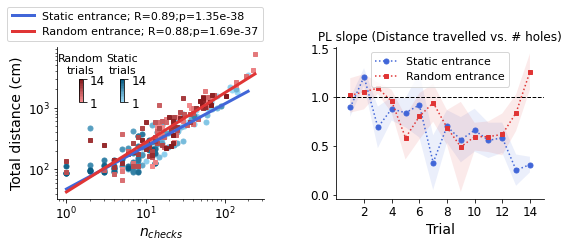

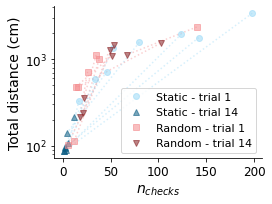

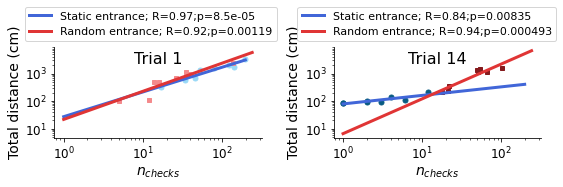

In [15]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
"""

# calculating the slowing down instants and positions in the 3 cm radius of holes
ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt ])
n_holes_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_ft ])
d_travel_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_rt ])
d_travel_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ])

linearize_func = numpy.log #lambda v: v
linreg_pl_func = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)

# substituting 0 by nan since this is a PL and we don't want zeros
n_holes_rt[n_holes_rt==0.0]=numpy.nan
n_holes_ft[n_holes_ft==0.0]=numpy.nan

linreg_rt        =   misc.linregress(linearize_func(n_holes_rt[:n_trials,:].flatten()), linearize_func(d_travel_rt[:n_trials,:].flatten()), alternative='two-sided')
linreg_ft        =   misc.linregress(linearize_func(n_holes_ft[:n_trials,:].flatten()), linearize_func(d_travel_ft[:n_trials,:].flatten()), alternative='two-sided')
linreg_trial_rt  = [ misc.linregress(linearize_func(n_holes_rt[k,:]                  ), linearize_func(d_travel_rt[k,:]                  ), alternative='two-sided') for k in range(n_trials) ]
linreg_trial_ft  = [ misc.linregress(linearize_func(n_holes_ft[k,:]                  ), linearize_func(d_travel_ft[k,:]                  ), alternative='two-sided') for k in range(n_trials) ]

slope_err_rt     = numpy.array([ (lr.slope,lr.stderr) for lr in linreg_trial_rt ]) # col 0 -> slope; col 1 -> error
slope_err_ft     = numpy.array([ (lr.slope,lr.stderr) for lr in linreg_trial_ft ]) # col 0 -> slope; col 1 -> error

#fh = plt.figure(figsize=FIGSIZE_1PANEL)
#ax = plt.gca()
#ax.set_position(AX_POS_1PANEL)
fh,ax = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=False,figsize=2*FIGSIZE_1PANEL)
ax_pos = AX_POS_1PANEL.copy()
ax_pos[2] *= 0.8
ax_pos[3] *= 0.8
AX_POS_2PANELS_mod = numpy.array([   ax_pos/2.0,
                                 [ 1.5*ax_pos[0]+ax_pos[2]/2      ,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ]])
ax[0].set_position(AX_POS_2PANELS_mod[0])
ax[1].set_position(AX_POS_2PANELS_mod[1])
ax[0],green_colors,red_colors = pltt.plot_scatter(ax[0],n_holes_rt,d_travel_rt,n_holes_ft,d_travel_ft,linreg_rt,linreg_ft,ind=None,use_log_for_linreg=True,linreg_func_internal=linreg_pl_func)
ax[0].legend(loc='lower right', bbox_to_anchor=(1.02, 1), fontsize=11)
ax[0].set_xlabel('$n_{checks}$')
ax[0].set_ylabel('Total distance (cm)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
cbar_rt,cax_rt = pltt._add_colorbar(ax[0],green_colors,p0=(0.35,0.8),title='Static\ntrials',minmax_tick_labels=['1',str(n_trials)],titleArgs=dict(fontsize=11))
cbar_ft,cax_ft = pltt._add_colorbar(ax[0],red_colors,  p0=(0.15,0.8),title='Random\ntrials',minmax_tick_labels=['1',str(n_trials)],titleArgs=dict(fontsize=11))
pltt.plot_errorfill(numpy.arange(n_trials)+1,slope_err_rt[:,0],slope_err_rt[:,1],fmt=':o',color=color_rt,markersize=5,ax=ax[1],label='Static entrance',alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,slope_err_ft[:,0],slope_err_ft[:,1],fmt=':s',color=color_ft,markersize=4,ax=ax[1],label='Random entrance',alpha_fill=0.1)
ax[1].set_xlim((0,n_trials+1))
pltt.plot_horizontal_lines(1,ax[1],linewidth=1,linestyle='--',color='k')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1), fontsize=11)
ax[1].set_xlabel('Trial')
ax[1].set_title('PL slope (Distance travelled vs. # holes)')
ax[1].set_xticks(numpy.arange(1,n_trials+1)[1::2])

pltt.set_box_axis(ax,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_scatter_n_holes_vs_dist_trav.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

fh,ax = plt.subplots(nrows=1,ncols=1,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
ax,green_colors,red_colors = pltt.plot_scatter(ax,n_holes_rt,d_travel_rt,n_holes_ft,d_travel_ft,
                                          linreg_rt=None,linreg_ft=None,ind=[0,n_trials-1],
                                          use_log_for_linreg=True,linreg_func_internal=linreg_pl_func,
                                          pSymbols_rt=['o','^'],pSymbols_ft=['s','v'],
                                          markersize_rt=[6],markersize_ft=[6],errorbarArgs_rt=dict(fillstyle='full'),errorbarArgs_ft=dict(fillstyle='full'),
                                          show_connecting_lines=True,connLines_args=dict(alpha=0.4),markerfacecolor_alpha=0.55)
ax.legend(['_']*16+['Static - trial 1','Static - trial 14','Random - trial 1','Random - trial 14'],loc='lower right', bbox_to_anchor=(1, 0),fontsize=11)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Total distance (cm)')
ax.set_yscale('log')

pltt.set_box_axis(ax,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_scatter_nholes_vs_dtravel_linear.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

fh,axt = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=2*FIGSIZE_1PANEL)
ax_pos = AX_POS_1PANEL.copy()
ax_pos[2] *= 0.8
ax_pos[3] *= 0.8
AX_POS_2PANELS_mod = numpy.array([   ax_pos/2.0,
                                 [ 1.5*ax_pos[0]+ax_pos[2]/2      ,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ]])
AX_POS_2PANELS_mod[:,-1] *= 0.6
axt[0].set_position(AX_POS_2PANELS_mod[0])
axt[1].set_position(AX_POS_2PANELS_mod[1])
axt[0],_,_ = pltt.plot_scatter(axt[0],n_holes_rt,d_travel_rt,n_holes_ft,d_travel_ft,linreg_trial_rt[0] ,linreg_trial_ft[0] ,ind=0,         use_log_for_linreg=True,green_colors=green_colors,red_colors=red_colors,linreg_func_internal=linreg_pl_func)
axt[1],_,_ = pltt.plot_scatter(axt[1],n_holes_rt,d_travel_rt,n_holes_ft,d_travel_ft,linreg_trial_rt[-1],linreg_trial_ft[-1],ind=n_trials-1,use_log_for_linreg=True,green_colors=green_colors,red_colors=red_colors,linreg_func_internal=linreg_pl_func)
axt[0].legend(loc='lower right', bbox_to_anchor=(1.1, 1),fontsize=11)
axt[1].legend(loc='lower right', bbox_to_anchor=(1.1, 1),fontsize=11)
axt[0].set_xlabel('$n_{checks}$')
axt[1].set_xlabel('$n_{checks}$')
axt[0].set_ylabel('Total distance (cm)')
axt[1].set_ylabel('Total distance (cm)')
axt[0].text(0.5,0.95,'Trial 1',          va='top',ha='center',transform=axt[0].transAxes,fontsize=LARGE_FONTSIZE)
axt[1].text(0.5,0.95,f'Trial {n_trials}',va='top',ha='center',transform=axt[1].transAxes,fontsize=LARGE_FONTSIZE)
axt[0].set_xscale('log');axt[0].set_yscale('log')
axt[1].set_xscale('log');axt[1].set_yscale('log')

pltt.set_box_axis(axt,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_vs_random_scatter_n_holes_vs_dist_trav_trial.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion density of hole checks vs. distance traveled

## loading extra trials

In [2]:
# experiments where mice are trained in "static entrance protocol" until first probe at least
# 2019-05-23 # preliminary
# 2021-06-22 # two targets
# 2021-11-19 # two targets
# 2022-08-12 # two targets rotated probe
# 2022-09-20 # two targets with rotated probe (female mice)
# 2022-10-11 # two targets rotated probe mixed sex
# 2022-11-04 # relative target (aka static entrance) - after trial 21 (at the probe), two mice (out of 4) get 90 degrees rotation

mouse_traj_dir_rt_1     = r'./experiments/relative_target/mouse_*'
#mouse_traj_dir_rt_2     = r'./experiments/preliminary/mouse_*'
mouse_traj_dir_rt_3     = r'./experiments/two_target_no_cues/mouse_*'
mouse_traj_dir_rt_4     = r'./experiments/two_targets_rot/mouse_*'
mouse_traj_dir_rt_5     = r'./experiments/two_targets_rot_fem/mouse_*'
mouse_traj_dir_rt_6     = r'./experiments/two_targets_rot_mixsex/mouse_*'
mouse_traj_dir_rt_7     = r'./experiments/relative_target_90deg/mouse_*'
time_delay_after_food  = 3.0 # sec
n_trial_max            = 14

trials_for_nchecks_1,_       = io.load_trial_file(mouse_traj_dir_rt_1,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
#trials_for_nchecks_2,_       = io.load_trial_file(mouse_traj_dir_rt_2,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_3,_       = io.load_trial_file(mouse_traj_dir_rt_3,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_4,_       = io.load_trial_file(mouse_traj_dir_rt_4,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_5,_       = io.load_trial_file(mouse_traj_dir_rt_5,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_6,_       = io.load_trial_file(mouse_traj_dir_rt_6,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_7,_       = io.load_trial_file(mouse_traj_dir_rt_7,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)

trials_for_nchecks_1         = tran.remove_path_after_food(trials_for_nchecks_1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
#trials_for_nchecks_2         = tran.remove_path_after_food(trials_for_nchecks_2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_3         = tran.remove_path_after_food(trials_for_nchecks_3,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_4         = tran.remove_path_after_food(trials_for_nchecks_4,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_5         = tran.remove_path_after_food(trials_for_nchecks_5,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_6         = tran.remove_path_after_food(trials_for_nchecks_6,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_7         = tran.remove_path_after_food(trials_for_nchecks_7,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)


# 14 trials, each containing 36 mice in "static entrance" condition
all_trials_for_density = io.group_track_list(misc.flatten_list([
        trials_for_nchecks_1,
        #trials_for_nchecks_2,
        trials_for_nchecks_3,
        trials_for_nchecks_4,
        trials_for_nchecks_5,
        trials_for_nchecks_6,
        trials_for_nchecks_7
    ],
    only_lists=True,return_list=True),group_by='trial',return_group_keys=False)

del trials_for_nchecks_1
del trials_for_nchecks_3
del trials_for_nchecks_4
del trials_for_nchecks_5
del trials_for_nchecks_6
del trials_for_nchecks_7

## n=36 static entrance (relative target)

 ... saving  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_density_checks_vs_distance_MANY_MICE.png


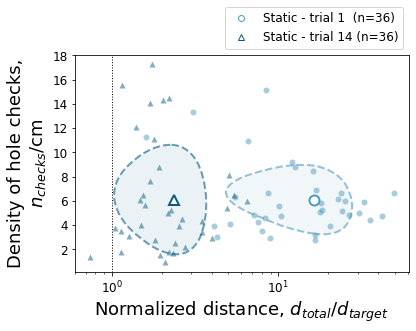

In [5]:
#"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
#"""

d_food_baseline_rt = numpy.array([ [ numpy.linalg.norm(tr.r_target-tr.r_start) for tr in all_mice ] for all_mice in all_trials_for_density ])
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)

set_x_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_for_density ])
n_holes_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_ft ])
d_travel_rt = numpy.divide(misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_for_density ]),d_food_baseline_rt)
d_travel_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ])/d_food_baseline_ft

# density of hole checks
n_holes_rt = numpy.divide(n_holes_rt.astype(float),d_travel_rt)
n_holes_ft = numpy.divide(n_holes_ft.astype(float),d_travel_ft)

n_holes_rt[ numpy.isnan( n_holes_rt)]=0.0
n_holes_ft[ numpy.isnan( n_holes_ft)]=0.0
d_travel_rt[numpy.isnan(d_travel_rt)]=0.0
d_travel_ft[numpy.isnan(d_travel_ft)]=0.0

n_d_cov_rt = misc.calc_dispersion_rows(d_travel_rt,n_holes_rt)
n_d_cov_ft = misc.calc_dispersion_rows(d_travel_ft,n_holes_ft)



colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

#fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
#ax[1].yaxis.set_tick_params(labelleft=True)
#ax[0].plot(n_holes_rt[0         ,:],d_travel_rt[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.8, label='Static - trial 1  (n=8)')
#ax[0].plot(n_holes_rt[n_trials-1,:],d_travel_rt[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.8, label='Static - trial 14 (n=8)')
#ax[0].plot(n_holes_ft[0         ,:],d_travel_ft[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.8, label='Random - trial 1  (n=8)')
#ax[0].plot(n_holes_ft[n_trials-1,:],d_travel_ft[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.8, label='Random - trial 14 (n=8)')
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(d_travel_rt[0         ,:],n_holes_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=36)')
ax.plot(d_travel_rt[n_trials-1,:],n_holes_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=36)')
#ax.plot(d_travel_ft[0         ,:],n_holes_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
#ax.plot(d_travel_ft[n_trials-1,:],n_holes_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(n_d_cov_rt[         0].r_mean,n_d_cov_rt[         0].r_eigdir,n_d_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_rt[n_trials-1].r_mean,n_d_cov_rt[n_trials-1].r_eigdir,n_d_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
#pltt.plot_dispersion(n_d_cov_ft[         0].r_mean,n_d_cov_ft[         0].r_eigdir,n_d_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
#pltt.plot_dispersion(n_d_cov_ft[n_trials-1].r_mean,n_d_cov_ft[n_trials-1].r_eigdir,n_d_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=36)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=36)' )
#ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
#ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(n_d_cov_rt[         0].r_mean[0] +  3, n_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(n_d_cov_rt[n_trials-1].r_mean[0] + 15, n_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(n_d_cov_ft[         0].r_mean[0] - 5 , n_d_cov_ft[         0].r_mean[1] + 3  ),xytext=(0.16,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(n_d_cov_ft[n_trials-1].r_mean[0] -  3, n_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.25,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_vertical_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)

if set_x_logscale:
    ax.set_xscale('log')
ax.set_xlabel('Normalized distance, $d_{total}/d_{target}$',fontsize=18)
ax.set_ylabel('Density of hole checks,\n$n_{checks}$/cm' ,fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)

ax.legend(loc='lower right', bbox_to_anchor=(1, 1),   fontsize=12)
#ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)

if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName   = f'{output_dir}/stat_vs_random_dispersion_density_checks_vs_distance_MANY_MICE.png'
    print(' ... saving ', fileName)
    plt.savefig(  fileName,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

## n=8 static entrance (relative target)

 ... saving  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_density_checks_vs_distance.png


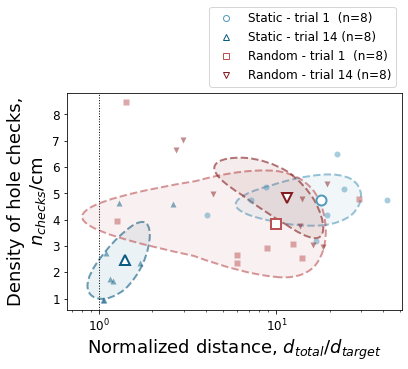

In [6]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)

set_x_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt ])
n_holes_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_ft ])
d_travel_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_rt ])/d_food_baseline_rt
d_travel_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ])/d_food_baseline_ft

# density of hole checks
n_holes_rt = numpy.divide(n_holes_rt.astype(float),d_travel_rt)
n_holes_ft = numpy.divide(n_holes_ft.astype(float),d_travel_ft)

n_holes_rt[ numpy.isnan( n_holes_rt)]=0.0
n_holes_ft[ numpy.isnan( n_holes_ft)]=0.0
d_travel_rt[numpy.isnan(d_travel_rt)]=0.0
d_travel_ft[numpy.isnan(d_travel_ft)]=0.0

n_d_cov_rt = misc.calc_dispersion_rows(d_travel_rt,n_holes_rt)
n_d_cov_ft = misc.calc_dispersion_rows(d_travel_ft,n_holes_ft)



colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

#fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
#ax[1].yaxis.set_tick_params(labelleft=True)
#ax[0].plot(n_holes_rt[0         ,:],d_travel_rt[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.8, label='Static - trial 1  (n=8)')
#ax[0].plot(n_holes_rt[n_trials-1,:],d_travel_rt[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.8, label='Static - trial 14 (n=8)')
#ax[0].plot(n_holes_ft[0         ,:],d_travel_ft[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.8, label='Random - trial 1  (n=8)')
#ax[0].plot(n_holes_ft[n_trials-1,:],d_travel_ft[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.8, label='Random - trial 14 (n=8)')
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(d_travel_rt[0         ,:],n_holes_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(d_travel_rt[n_trials-1,:],n_holes_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(d_travel_ft[0         ,:],n_holes_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(d_travel_ft[n_trials-1,:],n_holes_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(n_d_cov_rt[         0].r_mean,n_d_cov_rt[         0].r_eigdir,n_d_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_rt[n_trials-1].r_mean,n_d_cov_rt[n_trials-1].r_eigdir,n_d_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_ft[         0].r_mean,n_d_cov_ft[         0].r_eigdir,n_d_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_ft[n_trials-1].r_mean,n_d_cov_ft[n_trials-1].r_eigdir,n_d_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(n_d_cov_rt[         0].r_mean[0] +  3, n_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(n_d_cov_rt[n_trials-1].r_mean[0] + 15, n_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(n_d_cov_ft[         0].r_mean[0] - 5 , n_d_cov_ft[         0].r_mean[1] + 3  ),xytext=(0.16,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(n_d_cov_ft[n_trials-1].r_mean[0] -  3, n_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.25,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_vertical_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)

if set_x_logscale:
    ax.set_xscale('log')
ax.set_xlabel('Normalized distance, $d_{total}/d_{target}$',fontsize=18)
ax.set_ylabel('Density of hole checks,\n$n_{checks}$/cm' ,fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)

ax.legend(loc='lower right', bbox_to_anchor=(1, 1),   fontsize=12)
#ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)

if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName   = f'{output_dir}/stat_vs_random_dispersion_density_checks_vs_distance.png'
    print(' ... saving ', fileName)
    plt.savefig(  fileName,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion n_holes vs. distance traveled

 ... saving  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_n_holes_distance.png


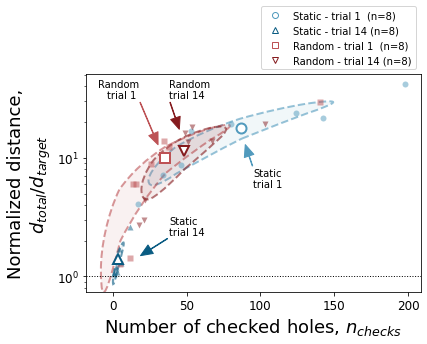

In [31]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)

set_y_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt ])
n_holes_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_ft ])
d_travel_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_rt ])/d_food_baseline_rt
d_travel_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ])/d_food_baseline_ft

n_holes_rt[ numpy.isnan( n_holes_rt)]=0.0
n_holes_ft[ numpy.isnan( n_holes_ft)]=0.0
d_travel_rt[numpy.isnan(d_travel_rt)]=0.0
d_travel_ft[numpy.isnan(d_travel_ft)]=0.0

n_d_cov_rt = misc.calc_dispersion_rows(n_holes_rt,d_travel_rt)
n_d_cov_ft = misc.calc_dispersion_rows(n_holes_ft,d_travel_ft)



colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

#fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
#ax[1].yaxis.set_tick_params(labelleft=True)
#ax[0].plot(n_holes_rt[0         ,:],d_travel_rt[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.8, label='Static - trial 1  (n=8)')
#ax[0].plot(n_holes_rt[n_trials-1,:],d_travel_rt[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.8, label='Static - trial 14 (n=8)')
#ax[0].plot(n_holes_ft[0         ,:],d_travel_ft[0         ,:],linestyle='none',markersize=7,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.8, label='Random - trial 1  (n=8)')
#ax[0].plot(n_holes_ft[n_trials-1,:],d_travel_ft[n_trials-1,:],linestyle='none',markersize=7,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.8, label='Random - trial 14 (n=8)')
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(n_holes_rt[0         ,:],d_travel_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(n_holes_rt[n_trials-1,:],d_travel_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(n_holes_ft[0         ,:],d_travel_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(n_holes_ft[n_trials-1,:],d_travel_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(n_d_cov_rt[         0].r_mean,n_d_cov_rt[         0].r_eigdir,n_d_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_rt[n_trials-1].r_mean,n_d_cov_rt[n_trials-1].r_eigdir,n_d_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_ft[         0].r_mean,n_d_cov_ft[         0].r_eigdir,n_d_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_ft[n_trials-1].r_mean,n_d_cov_ft[n_trials-1].r_eigdir,n_d_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
ax.annotate('Static\ntrial 1 ',xy=(n_d_cov_rt[         0].r_mean[0] +  3, n_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
ax.annotate('Static\ntrial 14',xy=(n_d_cov_rt[n_trials-1].r_mean[0] + 15, n_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
ax.annotate('Random\ntrial 1 ',xy=(n_d_cov_ft[         0].r_mean[0] - 5 , n_d_cov_ft[         0].r_mean[1] + 3  ),xytext=(0.16,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
ax.annotate('Random\ntrial 14',xy=(n_d_cov_ft[n_trials-1].r_mean[0] -  3, n_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.25,0.93),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_horizontal_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)

if set_y_logscale:
    ax.set_yscale('log')
ax.set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
ax.set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='lower right', bbox_to_anchor=(1, 1),   fontsize=10)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)
else:
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)

if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName   = f'{output_dir}/stat_vs_random_dispersion_n_holes_distance.png'
    print(' ... saving ', fileName)
    plt.savefig(  fileName,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion distance vs. speed

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_speed_distance.png


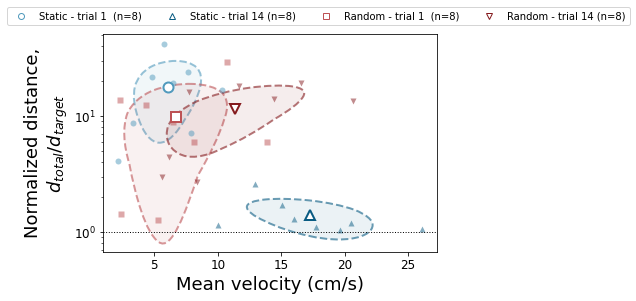

In [30]:
"""
###############
###############
###############
###############
############### distance vs.speed correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)

set_y_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_rt ])
v_mean_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_ft ])
d_travel_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_rt ])/d_food_baseline_rt
d_travel_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_ft ])/d_food_baseline_ft

v_mean_rt[  numpy.isnan( v_mean_rt )]=0.0
v_mean_ft[  numpy.isnan( v_mean_ft )]=0.0
d_travel_rt[numpy.isnan(d_travel_rt)]=0.0
d_travel_ft[numpy.isnan(d_travel_ft)]=0.0

v_d_cov_rt = misc.calc_dispersion_rows(v_mean_rt,d_travel_rt)
v_d_cov_ft = misc.calc_dispersion_rows(v_mean_ft,d_travel_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(v_mean_rt[0         ,:],d_travel_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(v_mean_rt[n_trials-1,:],d_travel_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(v_mean_ft[0         ,:],d_travel_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(v_mean_ft[n_trials-1,:],d_travel_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(v_d_cov_rt[         0].r_mean,v_d_cov_rt[         0].r_eigdir,v_d_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_rt[n_trials-1].r_mean,v_d_cov_rt[n_trials-1].r_eigdir,v_d_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_ft[         0].r_mean,v_d_cov_ft[         0].r_eigdir,v_d_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_ft[n_trials-1].r_mean,v_d_cov_ft[n_trials-1].r_eigdir,v_d_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(v_d_cov_rt[         0].r_mean[0] +  3, v_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(v_d_cov_rt[n_trials-1].r_mean[0] +  2, v_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(v_d_cov_ft[         0].r_mean[0] -  3, v_d_cov_ft[         0].r_mean[1] + 6  ),xytext=(0.2 ,0.9 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(v_d_cov_ft[n_trials-1].r_mean[0] -  3, v_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.26,0.92),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_horizontal_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)

if set_y_logscale:
    ax.set_yscale('log')
ax.set_xlabel('Mean velocity (cm/s)' ,fontsize=18)
ax.set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)
else:
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)

if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName =  f'{output_dir}/stat_vs_random_dispersion_speed_distance.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion d_perp vs. velocity

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_speed_d_perp.png


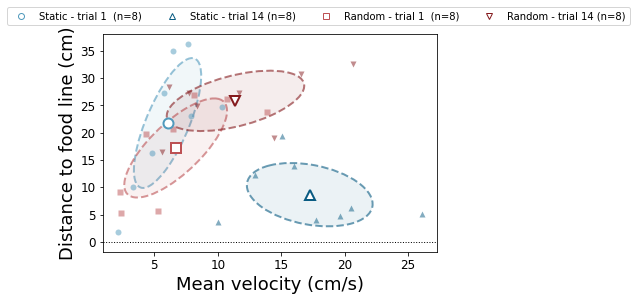

In [29]:
"""
###############
###############
###############
###############
############### perp distance vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False



# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_rt  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_rt ])
v_mean_ft  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_ft ])
d_perp_rt  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_rt ])
d_perp_ft  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_ft ])

v_mean_rt[numpy.isnan(v_mean_rt)]=0.0
v_mean_ft[numpy.isnan(v_mean_ft)]=0.0
d_perp_rt[numpy.isnan(d_perp_rt)]=0.0
d_perp_ft[numpy.isnan(d_perp_ft)]=0.0

v_d_cov_rt = misc.calc_dispersion_rows(v_mean_rt,d_perp_rt)
v_d_cov_ft = misc.calc_dispersion_rows(v_mean_ft,d_perp_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(v_mean_rt[0         ,:],d_perp_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(v_mean_rt[n_trials-1,:],d_perp_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(v_mean_ft[0         ,:],d_perp_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(v_mean_ft[n_trials-1,:],d_perp_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(v_d_cov_rt[         0].r_mean,v_d_cov_rt[         0].r_eigdir,v_d_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_rt[n_trials-1].r_mean,v_d_cov_rt[n_trials-1].r_eigdir,v_d_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_ft[         0].r_mean,v_d_cov_ft[         0].r_eigdir,v_d_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_ft[n_trials-1].r_mean,v_d_cov_ft[n_trials-1].r_eigdir,v_d_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(v_d_cov_rt[         0].r_mean[0] +  3, v_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(v_d_cov_rt[n_trials-1].r_mean[0] +  2, v_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(v_d_cov_ft[         0].r_mean[0] -  3, v_d_cov_ft[         0].r_mean[1] + 6  ),xytext=(0.2 ,0.9 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(v_d_cov_ft[n_trials-1].r_mean[0] -  3, v_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.26,0.92),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_horizontal_lines(0,ax=ax,linestyle=':',color='k',linewidth=1)

if set_y_logscale:
    ax.set_yscale('log')
ax.set_xlabel('Mean velocity (cm/s)' ,fontsize=18)
ax.set_ylabel('Distance to food line (cm)',fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)
else:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName =  f'{output_dir}/stat_vs_random_dispersion_speed_d_perp.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion heading angle vs. velocity

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_speed_headangle.png


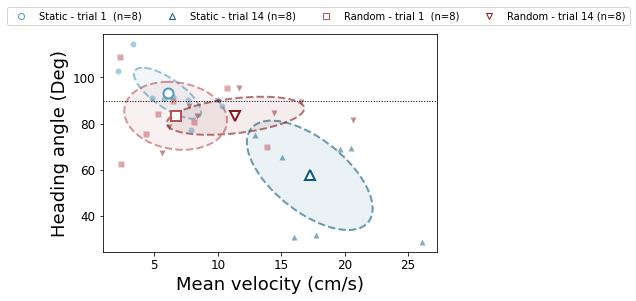

In [28]:
"""
###############
###############
###############
###############
############### heading angle vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False

# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_rt ])
v_mean_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_ft ])
ha_mean_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_rt ])
ha_mean_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_ft ])

v_mean_rt[ numpy.isnan( v_mean_rt)]=0.0
v_mean_ft[ numpy.isnan( v_mean_ft)]=0.0
ha_mean_rt[numpy.isnan(ha_mean_rt)]=0.0
ha_mean_ft[numpy.isnan(ha_mean_ft)]=0.0

v_ha_cov_rt = misc.calc_dispersion_rows(v_mean_rt,ha_mean_rt)
v_ha_cov_ft = misc.calc_dispersion_rows(v_mean_ft,ha_mean_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(v_mean_rt[0         ,:],ha_mean_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(v_mean_rt[n_trials-1,:],ha_mean_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(v_mean_ft[0         ,:],ha_mean_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(v_mean_ft[n_trials-1,:],ha_mean_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(v_ha_cov_rt[         0].r_mean,v_ha_cov_rt[         0].r_eigdir,v_ha_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_rt[n_trials-1].r_mean,v_ha_cov_rt[n_trials-1].r_eigdir,v_ha_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_ha_cov_ft[         0].r_mean,v_ha_cov_ft[         0].r_eigdir,v_ha_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_ft[n_trials-1].r_mean,v_ha_cov_ft[n_trials-1].r_eigdir,v_ha_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(v_d_cov_rt[         0].r_mean[0] +  3, v_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(v_d_cov_rt[n_trials-1].r_mean[0] +  2, v_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(v_d_cov_ft[         0].r_mean[0] -  3, v_d_cov_ft[         0].r_mean[1] + 6  ),xytext=(0.2 ,0.9 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(v_d_cov_ft[n_trials-1].r_mean[0] -  3, v_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.26,0.92),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_horizontal_lines(90,ax=ax,linestyle=':',color='k',linewidth=1)

if set_y_logscale:
    ax.set_yscale('log')
ax.set_xlabel('Mean velocity (cm/s)' ,fontsize=18)
ax.set_ylabel('Heading angle (Deg)',fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)
else:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_dispersion_speed_headangle.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion heading angle vs. distance perp

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_dispersion_headangle_d_perp.png


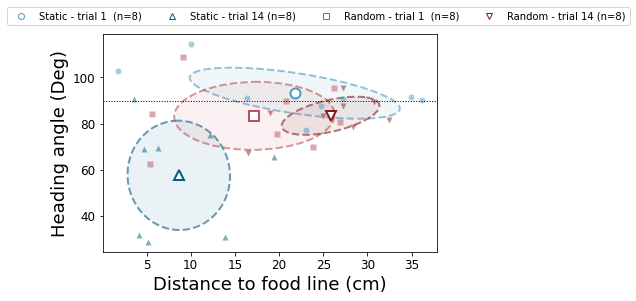

In [27]:
"""
###############
###############
###############
###############
############### heading angle vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False

# creating observation matrices
# rows -> trial
# cols -> observations of each trial
d_perp_rt   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_rt ])
d_perp_ft   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_ft ])
ha_mean_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_rt ])
ha_mean_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_ft ])

d_perp_rt[ numpy.isnan( d_perp_rt)]=0.0
d_perp_ft[ numpy.isnan( d_perp_ft)]=0.0
ha_mean_rt[numpy.isnan(ha_mean_rt)]=0.0
ha_mean_ft[numpy.isnan(ha_mean_ft)]=0.0

d_ha_cov_rt = misc.calc_dispersion_rows(d_perp_rt,ha_mean_rt)
d_ha_cov_ft = misc.calc_dispersion_rows(d_perp_ft,ha_mean_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)
ax.plot(d_perp_rt[0         ,:],ha_mean_rt[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static - trial 1  (n=8)')
ax.plot(d_perp_rt[n_trials-1,:],ha_mean_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static - trial 14 (n=8)')
ax.plot(d_perp_ft[0         ,:],ha_mean_ft[0         ,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random - trial 1  (n=8)')
ax.plot(d_perp_ft[n_trials-1,:],ha_mean_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random - trial 14 (n=8)')
pltt.plot_dispersion(d_ha_cov_rt[         0].r_mean,d_ha_cov_rt[         0].r_eigdir,d_ha_cov_rt[         0].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_rt[n_trials-1].r_mean,d_ha_cov_rt[n_trials-1].r_eigdir,d_ha_cov_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(d_ha_cov_ft[         0].r_mean,d_ha_cov_ft[         0].r_eigdir,d_ha_cov_ft[         0].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_ft[n_trials-1].r_mean,d_ha_cov_ft[n_trials-1].r_eigdir,d_ha_cov_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static - trial 14 (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random - trial 1  (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random - trial 14 (n=8)' )
#ax.annotate('Static\ntrial 1 ',xy=(v_d_cov_rt[         0].r_mean[0] +  3, v_d_cov_rt[         0].r_mean[1] - 5  ),xytext=(0.5 ,0.57),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax.annotate('Static\ntrial 14',xy=(v_d_cov_rt[n_trials-1].r_mean[0] +  2, v_d_cov_rt[n_trials-1].r_mean[1] + 0.1),xytext=(0.25,0.3 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='center')
#ax.annotate('Random\ntrial 1 ',xy=(v_d_cov_ft[         0].r_mean[0] -  3, v_d_cov_ft[         0].r_mean[1] + 6  ),xytext=(0.2 ,0.9 ),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='center',ha='right')
#ax.annotate('Random\ntrial 14',xy=(v_d_cov_ft[n_trials-1].r_mean[0] -  3, v_d_cov_ft[n_trials-1].r_mean[1] + 6  ),xytext=(0.26,0.92),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='center')
pltt.plot_horizontal_lines(90,ax=ax,linestyle=':',color='k',linewidth=1)

if set_y_logscale:
    ax.set_yscale('log')
ax.set_xlabel('Distance to food line (cm)' ,fontsize=18)
ax.set_ylabel('Heading angle (Deg)',fontsize=18)
#ax[1].set_xlabel('Number of checked holes, $n_{checks}$' ,fontsize=18)
#ax[1].set_ylabel('Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=14)
else:
    ax.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.02),   fontsize=10, ncol=4)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)

if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName =  f'{output_dir}/stat_vs_random_dispersion_headangle_d_perp.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion (half) density of checks vs. distance travelled

 ... saving  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_density_checks_vs_distance.png
 ... saving  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_density_checks_vs_distance_detail.png


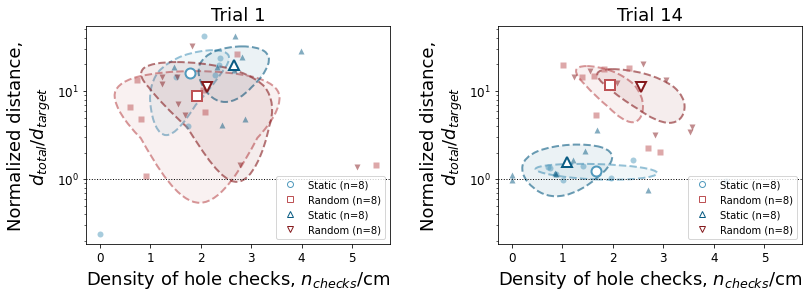

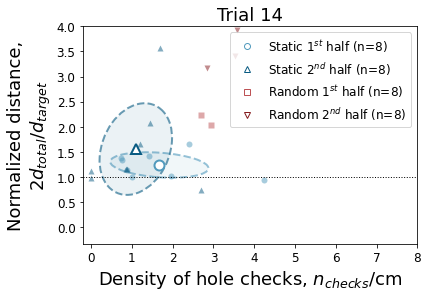

In [16]:
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran
#
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt
#
#del sys.modules['modules.helper_func_class']
#del misc
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)/2.0
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)/2.0

set_y_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_h1_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h1_rt ])
n_holes_h1_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h1_ft ])
d_travel_h1_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_rt ])/d_food_baseline_rt
d_travel_h1_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_ft ])/d_food_baseline_ft

n_holes_h2_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h2_rt ])
n_holes_h2_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h2_ft ])
d_travel_h2_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_rt ])/d_food_baseline_rt
d_travel_h2_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_ft ])/d_food_baseline_ft


n_holes_h1_rt = numpy.divide(n_holes_h1_rt.astype(float),d_travel_h1_rt)
n_holes_h1_ft = numpy.divide(n_holes_h1_ft.astype(float),d_travel_h1_ft)
n_holes_h2_rt = numpy.divide(n_holes_h2_rt.astype(float),d_travel_h2_rt)
n_holes_h2_ft = numpy.divide(n_holes_h2_ft.astype(float),d_travel_h2_ft)

n_holes_h1_rt[ numpy.isnan( n_holes_h1_rt)]=0.0
n_holes_h1_ft[ numpy.isnan( n_holes_h1_ft)]=0.0
d_travel_h1_rt[numpy.isnan(d_travel_h1_rt)]=0.0
d_travel_h1_ft[numpy.isnan(d_travel_h1_ft)]=0.0
n_holes_h2_rt[ numpy.isnan( n_holes_h2_rt)]=0.0
n_holes_h2_ft[ numpy.isnan( n_holes_h2_ft)]=0.0
d_travel_h2_rt[numpy.isnan(d_travel_h2_rt)]=0.0
d_travel_h2_ft[numpy.isnan(d_travel_h2_ft)]=0.0

n_d_cov_h1_rt = misc.calc_dispersion_rows(n_holes_h1_rt,d_travel_h1_rt)
n_d_cov_h1_ft = misc.calc_dispersion_rows(n_holes_h1_ft,d_travel_h1_ft)
n_d_cov_h2_rt = misc.calc_dispersion_rows(n_holes_h2_rt,d_travel_h2_rt)
n_d_cov_h2_ft = misc.calc_dispersion_rows(n_holes_h2_ft,d_travel_h2_ft)



colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(n_holes_h1_rt[0,:],d_travel_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(n_holes_h1_ft[0,:],d_travel_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(n_holes_h2_rt[0,:],d_travel_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(n_holes_h2_ft[0,:],d_travel_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[0].r_mean,n_d_cov_h1_rt[0].r_eigdir,n_d_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[0].r_mean,n_d_cov_h1_ft[0].r_eigdir,n_d_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[0].r_mean,n_d_cov_h2_rt[0].r_eigdir,n_d_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[0].r_mean,n_d_cov_h2_ft[0].r_eigdir,n_d_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random (n=8)' )
#ax[0].annotate('Static\n1$^{st}$ half',xy=(n_d_cov_h1_rt[0].r_mean[0] + 10, n_d_cov_h1_rt[0].r_mean[1] - 5 ),xytext=(0.60,0.55),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')          # xytext=(40,-30 ),textcoords='offset pixels'
#ax[0].annotate('Random\n1$^{st}$ half',xy=(n_d_cov_h1_ft[0].r_mean[0] + 1 , n_d_cov_h1_ft[0].r_mean[1] - 3 ),xytext=(0.22,0.20),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left')# xytext=(10,-80 ),textcoords='offset pixels'
#ax[0].annotate('Static\n2$^{nd}$ half',xy=(n_d_cov_h2_rt[0].r_mean[0] + 8 , n_d_cov_h2_rt[0].r_mean[1] - 5 ),xytext=(0.75,0.70),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left')# xytext=(40,-20 ),textcoords='offset pixels'
#ax[0].annotate('Random\n2$^{nd}$ half',xy=(n_d_cov_h2_ft[0].r_mean[0] + 5 , n_d_cov_h2_ft[0].r_mean[1] - 4 ),xytext=(0.35,0.50),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left')# xytext=(30,-40 ),textcoords='offset pixels'
pltt.plot_horizontal_lines(1,ax=ax[0],linestyle=':',color='k',linewidth=1)




ax[1].plot(n_holes_h1_rt[n_trials-1,:],d_travel_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(n_holes_h1_ft[n_trials-1,:],d_travel_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(n_holes_h2_rt[n_trials-1,:],d_travel_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(n_holes_h2_ft[n_trials-1,:],d_travel_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[n_trials-1].r_mean,n_d_cov_h1_rt[n_trials-1].r_eigdir,n_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[n_trials-1].r_mean,n_d_cov_h1_ft[n_trials-1].r_eigdir,n_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[n_trials-1].r_mean,n_d_cov_h2_rt[n_trials-1].r_eigdir,n_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[n_trials-1].r_mean,n_d_cov_h2_ft[n_trials-1].r_eigdir,n_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random (n=8)' )
#ax[1].annotate('Static\n1$^{st}$ half',xy=(n_d_cov_h1_rt[n_trials-1].r_mean[0] + 5 , n_d_cov_h1_rt[n_trials-1].r_mean[1] - 0.2 ),xytext=(0.22,0.20),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')           # xytext=(40,-30 ),textcoords='offset pixels'
#ax[1].annotate('Random\n1$^{st}$ half',xy=(n_d_cov_h1_ft[n_trials-1].r_mean[0] + 8 , n_d_cov_h1_ft[n_trials-1].r_mean[1] - 5   ),xytext=(0.38,0.50),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left') # xytext=(50,-30 ),textcoords='offset pixels'
#ax[1].annotate('Static\n2$^{nd}$ half',xy=(n_d_cov_h2_rt[n_trials-1].r_mean[0] + 5 , n_d_cov_h2_rt[n_trials-1].r_mean[1] - 0   ),xytext=(0.25,0.37),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left') # xytext=(50,  0 ),textcoords='offset pixels'
#ax[1].annotate('Random\n2$^{nd}$ half',xy=(n_d_cov_h2_ft[n_trials-1].r_mean[0] + 10, n_d_cov_h2_ft[n_trials-1].r_mean[1] - 0   ),xytext=(0.53,0.68),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left') # xytext=(60,-10 ),textcoords='offset pixels'
pltt.plot_horizontal_lines(1,ax=ax[1],linestyle=':',color='k',linewidth=1)

ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Density of hole checks, $n_{checks}$/cm'     ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
    ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
    ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName   = f'{output_dir}/stat_vs_random_HALF_dispersion_density_checks_vs_distance.png'
    print(' ... saving ', fileName)
    plt.savefig(  fileName,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)

ax.plot(n_holes_h1_rt[n_trials-1,:],d_travel_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax.plot(n_holes_h1_ft[n_trials-1,:],d_travel_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax.plot(n_holes_h2_rt[n_trials-1,:],d_travel_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax.plot(n_holes_h2_ft[n_trials-1,:],d_travel_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[n_trials-1].r_mean,n_d_cov_h1_rt[n_trials-1].r_eigdir,n_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[n_trials-1].r_mean,n_d_cov_h1_ft[n_trials-1].r_eigdir,n_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[n_trials-1].r_mean,n_d_cov_h2_rt[n_trials-1].r_eigdir,n_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[n_trials-1].r_mean,n_d_cov_h2_ft[n_trials-1].r_eigdir,n_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )

ax.set_xlim(right=8)
ax.set_ylim(top=4)

pltt.plot_horizontal_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)


ax.set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    #ax.set_yscale('log')
    pass
pltt.set_xlabel(ax=ax,label='Density of hole checks, $n_{checks}$/cm'      ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Normalized distance,\n$2d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1),   fontsize=12)
else:
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1),   fontsize=12)


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName   = f'{output_dir}/stat_vs_random_HALF_dispersion_density_checks_vs_distance_detail.png'
    print(' ... saving ', fileName)
    plt.savefig(  fileName,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion (half) n_holes vs. distance traveled

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_n_holes_distance.png
 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_n_holes_distance_detail.png


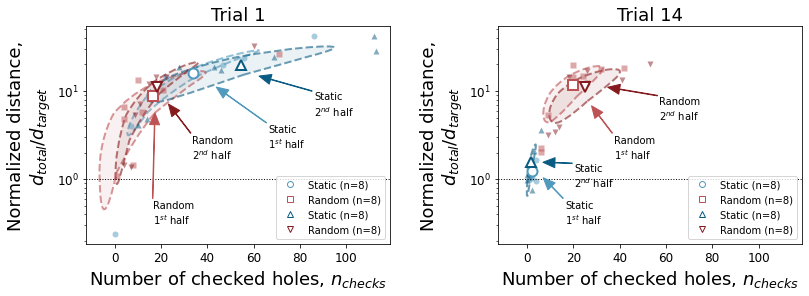

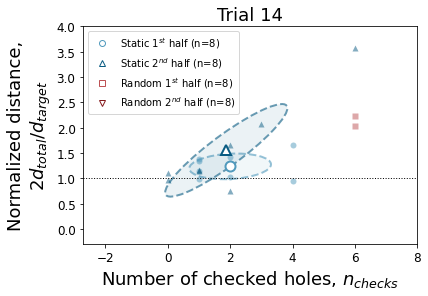

In [26]:
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran
#
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt
#
#del sys.modules['modules.helper_func_class']
#del misc
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES vs. distance travelled correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)/2.0
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)/2.0

set_y_logscale = True

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s


all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
n_holes_h1_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h1_rt ])
n_holes_h1_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h1_ft ])
d_travel_h1_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_rt ])/d_food_baseline_rt
d_travel_h1_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_ft ])/d_food_baseline_ft

n_holes_h2_rt  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h2_rt ])
n_holes_h2_ft  = misc.asarray_nanfill([ tran.calc_number_checked_holes(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_h2_ft ])
d_travel_h2_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_rt ])/d_food_baseline_rt
d_travel_h2_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_ft ])/d_food_baseline_ft


n_holes_h1_rt[ numpy.isnan( n_holes_h1_rt)]=0.0
n_holes_h1_ft[ numpy.isnan( n_holes_h1_ft)]=0.0
d_travel_h1_rt[numpy.isnan(d_travel_h1_rt)]=0.0
d_travel_h1_ft[numpy.isnan(d_travel_h1_ft)]=0.0
n_holes_h2_rt[ numpy.isnan( n_holes_h2_rt)]=0.0
n_holes_h2_ft[ numpy.isnan( n_holes_h2_ft)]=0.0
d_travel_h2_rt[numpy.isnan(d_travel_h2_rt)]=0.0
d_travel_h2_ft[numpy.isnan(d_travel_h2_ft)]=0.0

n_d_cov_h1_rt = misc.calc_dispersion_rows(n_holes_h1_rt,d_travel_h1_rt)
n_d_cov_h1_ft = misc.calc_dispersion_rows(n_holes_h1_ft,d_travel_h1_ft)
n_d_cov_h2_rt = misc.calc_dispersion_rows(n_holes_h2_rt,d_travel_h2_rt)
n_d_cov_h2_ft = misc.calc_dispersion_rows(n_holes_h2_ft,d_travel_h2_ft)



colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(n_holes_h1_rt[0,:],d_travel_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(n_holes_h1_ft[0,:],d_travel_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(n_holes_h2_rt[0,:],d_travel_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(n_holes_h2_ft[0,:],d_travel_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[0].r_mean,n_d_cov_h1_rt[0].r_eigdir,n_d_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[0].r_mean,n_d_cov_h1_ft[0].r_eigdir,n_d_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[0].r_mean,n_d_cov_h2_rt[0].r_eigdir,n_d_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[0].r_mean,n_d_cov_h2_ft[0].r_eigdir,n_d_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random (n=8)' )
ax[0].annotate('Static\n1$^{st}$ half',xy=(n_d_cov_h1_rt[0].r_mean[0] + 10, n_d_cov_h1_rt[0].r_mean[1] - 5 ),xytext=(0.60,0.55),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')          # xytext=(40,-30 ),textcoords='offset pixels'
ax[0].annotate('Random\n1$^{st}$ half',xy=(n_d_cov_h1_ft[0].r_mean[0] + 1 , n_d_cov_h1_ft[0].r_mean[1] - 3 ),xytext=(0.22,0.20),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left')# xytext=(10,-80 ),textcoords='offset pixels'
ax[0].annotate('Static\n2$^{nd}$ half',xy=(n_d_cov_h2_rt[0].r_mean[0] + 8 , n_d_cov_h2_rt[0].r_mean[1] - 5 ),xytext=(0.75,0.70),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left')# xytext=(40,-20 ),textcoords='offset pixels'
ax[0].annotate('Random\n2$^{nd}$ half',xy=(n_d_cov_h2_ft[0].r_mean[0] + 5 , n_d_cov_h2_ft[0].r_mean[1] - 4 ),xytext=(0.35,0.50),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left')# xytext=(30,-40 ),textcoords='offset pixels'
pltt.plot_horizontal_lines(1,ax=ax[0],linestyle=':',color='k',linewidth=1)




ax[1].plot(n_holes_h1_rt[n_trials-1,:],d_travel_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(n_holes_h1_ft[n_trials-1,:],d_travel_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(n_holes_h2_rt[n_trials-1,:],d_travel_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(n_holes_h2_ft[n_trials-1,:],d_travel_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[n_trials-1].r_mean,n_d_cov_h1_rt[n_trials-1].r_eigdir,n_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[n_trials-1].r_mean,n_d_cov_h1_ft[n_trials-1].r_eigdir,n_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[n_trials-1].r_mean,n_d_cov_h2_rt[n_trials-1].r_eigdir,n_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[n_trials-1].r_mean,n_d_cov_h2_ft[n_trials-1].r_eigdir,n_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random (n=8)' )
ax[1].annotate('Static\n1$^{st}$ half',xy=(n_d_cov_h1_rt[n_trials-1].r_mean[0] + 5 , n_d_cov_h1_rt[n_trials-1].r_mean[1] - 0.2 ),xytext=(0.22,0.20),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')           # xytext=(40,-30 ),textcoords='offset pixels'
ax[1].annotate('Random\n1$^{st}$ half',xy=(n_d_cov_h1_ft[n_trials-1].r_mean[0] + 8 , n_d_cov_h1_ft[n_trials-1].r_mean[1] - 5   ),xytext=(0.38,0.50),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left') # xytext=(50,-30 ),textcoords='offset pixels'
ax[1].annotate('Static\n2$^{nd}$ half',xy=(n_d_cov_h2_rt[n_trials-1].r_mean[0] + 5 , n_d_cov_h2_rt[n_trials-1].r_mean[1] - 0   ),xytext=(0.25,0.37),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left') # xytext=(50,  0 ),textcoords='offset pixels'
ax[1].annotate('Random\n2$^{nd}$ half',xy=(n_d_cov_h2_ft[n_trials-1].r_mean[0] + 10, n_d_cov_h2_ft[n_trials-1].r_mean[1] - 0   ),xytext=(0.53,0.68),textcoords='axes fraction',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left') # xytext=(60,-10 ),textcoords='offset pixels'
pltt.plot_horizontal_lines(1,ax=ax[1],linestyle=':',color='k',linewidth=1)

ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Number of checked holes, $n_{checks}$'       ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
    ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
    ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_n_holes_distance.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharey=True,sharex=True)

ax.plot(n_holes_h1_rt[n_trials-1,:],d_travel_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax.plot(n_holes_h1_ft[n_trials-1,:],d_travel_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax.plot(n_holes_h2_rt[n_trials-1,:],d_travel_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax.plot(n_holes_h2_ft[n_trials-1,:],d_travel_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(n_d_cov_h1_rt[n_trials-1].r_mean,n_d_cov_h1_rt[n_trials-1].r_eigdir,n_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h1_ft[n_trials-1].r_mean,n_d_cov_h1_ft[n_trials-1].r_eigdir,n_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(n_d_cov_h2_rt[n_trials-1].r_mean,n_d_cov_h2_rt[n_trials-1].r_eigdir,n_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(n_d_cov_h2_ft[n_trials-1].r_mean,n_d_cov_h2_ft[n_trials-1].r_eigdir,n_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax,color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax.plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )

ax.set_xlim(right=8)
ax.set_ylim(top=4)

pltt.plot_horizontal_lines(1,ax=ax,linestyle=':',color='k',linewidth=1)


ax.set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    #ax.set_yscale('log')
    pass
pltt.set_xlabel(ax=ax,label='Number of checked holes, $n_{checks}$'       ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Normalized distance,\n$2d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=10)
else:
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_n_holes_distance_detail.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion (half) distance vs. speed

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_speed_distance.png


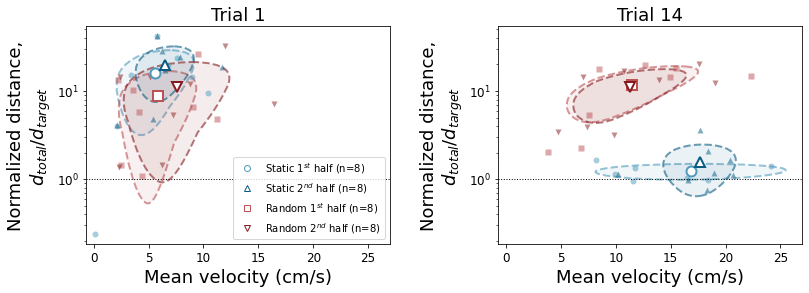

In [25]:
"""
###############
###############
###############
###############
############### distance vs.speed correlation
###############
###############
###############
###############
"""

d_food_baseline_rt = numpy.linalg.norm(all_trials_rt[0][0].r_target-all_trials_rt[0][0].r_start)/2.0
d_food_baseline_ft = numpy.linalg.norm(all_trials_ft[0][0].r_target-all_trials_ft[0][0].r_start)/2.0


all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)


set_y_logscale = True


# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_h1_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_rt ])
v_mean_h1_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_ft ])
d_travel_h1_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_rt ])/d_food_baseline_rt
d_travel_h1_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h1_ft ])/d_food_baseline_ft
v_mean_h2_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_rt ])
v_mean_h2_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_ft ])
d_travel_h2_rt = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_rt ])/d_food_baseline_rt
d_travel_h2_ft = misc.asarray_nanfill([ tran.calc_traveled_dist(all_mice) for all_mice in all_trials_h2_ft ])/d_food_baseline_ft

v_mean_h1_rt[  numpy.isnan(  v_mean_h1_rt)]=0.0
v_mean_h1_ft[  numpy.isnan(  v_mean_h1_ft)]=0.0
d_travel_h1_rt[numpy.isnan(d_travel_h1_rt)]=0.0
d_travel_h1_ft[numpy.isnan(d_travel_h1_ft)]=0.0
v_mean_h2_rt[  numpy.isnan(  v_mean_h2_rt)]=0.0
v_mean_h2_ft[  numpy.isnan(  v_mean_h2_ft)]=0.0
d_travel_h2_rt[numpy.isnan(d_travel_h2_rt)]=0.0
d_travel_h2_ft[numpy.isnan(d_travel_h2_ft)]=0.0

v_d_cov_h1_rt = misc.calc_dispersion_rows(v_mean_h1_rt,d_travel_h1_rt)
v_d_cov_h1_ft = misc.calc_dispersion_rows(v_mean_h1_ft,d_travel_h1_ft)
v_d_cov_h2_rt = misc.calc_dispersion_rows(v_mean_h2_rt,d_travel_h2_rt)
v_d_cov_h2_ft = misc.calc_dispersion_rows(v_mean_h2_ft,d_travel_h2_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(v_mean_h1_rt[0,:],d_travel_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h1_ft[0,:],d_travel_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(v_mean_h2_rt[0,:],d_travel_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h2_ft[0,:],d_travel_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_d_cov_h1_rt[0].r_mean,v_d_cov_h1_rt[0].r_eigdir,v_d_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h1_ft[0].r_mean,v_d_cov_h1_ft[0].r_eigdir,v_d_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h2_rt[0].r_mean,v_d_cov_h2_rt[0].r_eigdir,v_d_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_h2_ft[0].r_mean,v_d_cov_h2_ft[0].r_eigdir,v_d_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
#ax[0].annotate('Static\n1$^{st}$ half',xy=(v_d_cov_h1_rt[0].r_mean[0] + 10, v_d_cov_h1_rt[0].r_mean[1] - 5 ),xytext=(40,-30 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax[0].annotate('Random\n1$^{st}$ half',xy=(v_d_cov_h1_ft[0].r_mean[0] + 1 , v_d_cov_h1_ft[0].r_mean[1] - 3 ),xytext=(10,-80 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left')
#ax[0].annotate('Static\n2$^{nd}$ half',xy=(v_d_cov_h2_rt[0].r_mean[0] + 8 , v_d_cov_h2_rt[0].r_mean[1] - 5 ),xytext=(40,-20 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left')
#ax[0].annotate('Random\n2$^{nd}$ half',xy=(v_d_cov_h2_ft[0].r_mean[0] + 5 , v_d_cov_h2_ft[0].r_mean[1] - 4 ),xytext=(30,-40 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left')
ax[0].set_xlim(right=27)
pltt.plot_horizontal_lines(1,ax=ax[0],linestyle=':',color='k',linewidth=1)




ax[1].plot(v_mean_h1_rt[n_trials-1,:],d_travel_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h1_ft[n_trials-1,:],d_travel_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(v_mean_h2_rt[n_trials-1,:],d_travel_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h2_ft[n_trials-1,:],d_travel_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_d_cov_h1_rt[n_trials-1].r_mean,v_d_cov_h1_rt[n_trials-1].r_eigdir,v_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h1_ft[n_trials-1].r_mean,v_d_cov_h1_ft[n_trials-1].r_eigdir,v_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h2_rt[n_trials-1].r_mean,v_d_cov_h2_rt[n_trials-1].r_eigdir,v_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_h2_ft[n_trials-1].r_mean,v_d_cov_h2_ft[n_trials-1].r_eigdir,v_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
#ax[1].annotate('Static\n1$^{st}$ half',xy=(v_d_cov_h1_rt[n_trials-1].r_mean[0] + 5 , v_d_cov_h1_rt[n_trials-1].r_mean[1] - 0.2 ),xytext=(40,-30 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[ 0]),va='top')
#ax[1].annotate('Random\n1$^{st}$ half',xy=(v_d_cov_h1_ft[n_trials-1].r_mean[0] + 8 , v_d_cov_h1_ft[n_trials-1].r_mean[1] - 5 ),xytext=(50,-30 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[ 0]),va='top',ha='left')
#ax[1].annotate('Static\n2$^{nd}$ half',xy=(v_d_cov_h2_rt[n_trials-1].r_mean[0] + 5 , v_d_cov_h2_rt[n_trials-1].r_mean[1] - 0 ),xytext=(50,  0 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_rt[-1]),va='top',ha='left')
#ax[1].annotate('Random\n2$^{nd}$ half',xy=(v_d_cov_h2_ft[n_trials-1].r_mean[0] + 10, v_d_cov_h2_ft[n_trials-1].r_mean[1] - 0 ),xytext=(60,-10 ),textcoords='offset pixels',xycoords='data',arrowprops=dict(headwidth=10,width=0.5,color=colors_ft[-1]),va='top',ha='left')
pltt.plot_horizontal_lines(1,ax=ax[1],linestyle=':',color='k',linewidth=1)

ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Mean velocity (cm/s)'                        ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Normalized distance,\n$d_{total}/d_{target}$',fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
    #ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
    #ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1),   fontsize=12)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_speed_distance.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion (half) d_perp vs. velocity

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_speed_d_perp.png


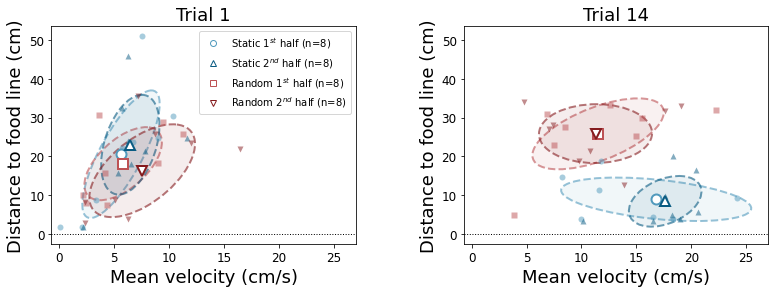

In [24]:
"""
###############
###############
###############
###############
############### perp distance vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False

all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)

# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_h1_rt  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_rt ])
v_mean_h1_ft  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_ft ])
d_perp_h1_rt  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h1_rt ])
d_perp_h1_ft  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h1_ft ])
v_mean_h2_rt  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_rt ])
v_mean_h2_ft  = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_ft ])
d_perp_h2_rt  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h2_rt ])
d_perp_h2_ft  = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h2_ft ])


v_mean_h1_rt[numpy.isnan(v_mean_h1_rt)]=0.0
v_mean_h1_ft[numpy.isnan(v_mean_h1_ft)]=0.0
d_perp_h1_rt[numpy.isnan(d_perp_h1_rt)]=0.0
d_perp_h1_ft[numpy.isnan(d_perp_h1_ft)]=0.0
v_mean_h2_rt[numpy.isnan(v_mean_h2_rt)]=0.0
v_mean_h2_ft[numpy.isnan(v_mean_h2_ft)]=0.0
d_perp_h2_rt[numpy.isnan(d_perp_h2_rt)]=0.0
d_perp_h2_ft[numpy.isnan(d_perp_h2_ft)]=0.0



v_d_cov_h1_rt = misc.calc_dispersion_rows(v_mean_h1_rt,d_perp_h1_rt)
v_d_cov_h1_ft = misc.calc_dispersion_rows(v_mean_h1_ft,d_perp_h1_ft)
v_d_cov_h2_rt = misc.calc_dispersion_rows(v_mean_h2_rt,d_perp_h2_rt)
v_d_cov_h2_ft = misc.calc_dispersion_rows(v_mean_h2_ft,d_perp_h2_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(v_mean_h1_rt[0,:],d_perp_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h1_ft[0,:],d_perp_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(v_mean_h2_rt[0,:],d_perp_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h2_ft[0,:],d_perp_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_d_cov_h1_rt[0].r_mean,v_d_cov_h1_rt[0].r_eigdir,v_d_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h1_ft[0].r_mean,v_d_cov_h1_ft[0].r_eigdir,v_d_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h2_rt[0].r_mean,v_d_cov_h2_rt[0].r_eigdir,v_d_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_h2_ft[0].r_mean,v_d_cov_h2_ft[0].r_eigdir,v_d_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
ax[0].set_xlim(right=27)
pltt.plot_horizontal_lines(0,ax=ax[0],linestyle=':',color='k',linewidth=1)




ax[1].plot(v_mean_h1_rt[n_trials-1,:],d_perp_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h1_ft[n_trials-1,:],d_perp_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(v_mean_h2_rt[n_trials-1,:],d_perp_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h2_ft[n_trials-1,:],d_perp_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_d_cov_h1_rt[n_trials-1].r_mean,v_d_cov_h1_rt[n_trials-1].r_eigdir,v_d_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h1_ft[n_trials-1].r_mean,v_d_cov_h1_ft[n_trials-1].r_eigdir,v_d_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_d_cov_h2_rt[n_trials-1].r_mean,v_d_cov_h2_rt[n_trials-1].r_eigdir,v_d_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_d_cov_h2_ft[n_trials-1].r_mean,v_d_cov_h2_ft[n_trials-1].r_eigdir,v_d_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )

pltt.plot_horizontal_lines(0,ax=ax[1],linestyle=':',color='k',linewidth=1)

set_y_logscale=False
ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Mean velocity (cm/s)'      ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Distance to food line (cm)',fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1),   fontsize=10)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_speed_d_perp.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# Dispersion (half) heading angle vs. velocity

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_speed_headangle.png


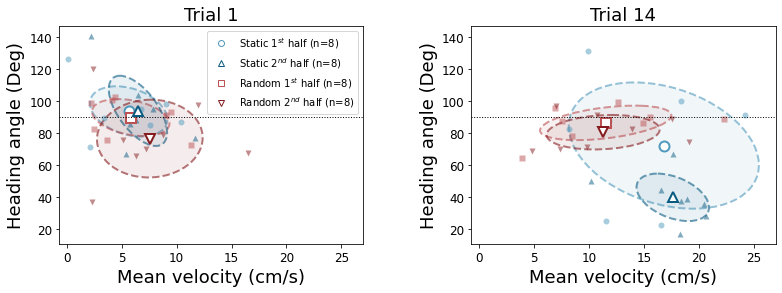

In [23]:
"""
###############
###############
###############
###############
############### heading angle vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False


all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)

# creating observation matrices
# rows -> trial
# cols -> observations of each trial
v_mean_h1_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_rt ])
v_mean_h1_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h1_ft ])
ha_mean_h1_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h1_rt ])
ha_mean_h1_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h1_ft ])
v_mean_h2_rt   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_rt ])
v_mean_h2_ft   = misc.asarray_nanfill([ tran.calc_mean_velocity(all_mice) for all_mice in all_trials_h2_ft ])
ha_mean_h2_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h2_rt ])
ha_mean_h2_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h2_ft ])

v_mean_h1_rt[ numpy.isnan( v_mean_h1_rt)]=0.0
v_mean_h1_ft[ numpy.isnan( v_mean_h1_ft)]=0.0
ha_mean_h1_rt[numpy.isnan(ha_mean_h1_rt)]=0.0
ha_mean_h1_ft[numpy.isnan(ha_mean_h1_ft)]=0.0
v_mean_h2_rt[ numpy.isnan( v_mean_h2_rt)]=0.0
v_mean_h2_ft[ numpy.isnan( v_mean_h2_ft)]=0.0
ha_mean_h2_rt[numpy.isnan(ha_mean_h2_rt)]=0.0
ha_mean_h2_ft[numpy.isnan(ha_mean_h2_ft)]=0.0

v_ha_cov_h1_rt = misc.calc_dispersion_rows(v_mean_h1_rt,ha_mean_h1_rt)
v_ha_cov_h1_ft = misc.calc_dispersion_rows(v_mean_h1_ft,ha_mean_h1_ft)
v_ha_cov_h2_rt = misc.calc_dispersion_rows(v_mean_h2_rt,ha_mean_h2_rt)
v_ha_cov_h2_ft = misc.calc_dispersion_rows(v_mean_h2_ft,ha_mean_h2_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(v_mean_h1_rt[0,:],ha_mean_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h1_ft[0,:],ha_mean_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(v_mean_h2_rt[0,:],ha_mean_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(v_mean_h2_ft[0,:],ha_mean_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_ha_cov_h1_rt[0].r_mean,v_ha_cov_h1_rt[0].r_eigdir,v_ha_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_h1_ft[0].r_mean,v_ha_cov_h1_ft[0].r_eigdir,v_ha_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_h2_rt[0].r_mean,v_ha_cov_h2_rt[0].r_eigdir,v_ha_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_ha_cov_h2_ft[0].r_mean,v_ha_cov_h2_ft[0].r_eigdir,v_ha_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
ax[0].set_xlim(right=27)
pltt.plot_horizontal_lines(90,ax=ax[0],linestyle=':',color='k',linewidth=1)



ax[1].plot(v_mean_h1_rt[n_trials-1,:],ha_mean_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h1_ft[n_trials-1,:],ha_mean_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(v_mean_h2_rt[n_trials-1,:],ha_mean_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(v_mean_h2_ft[n_trials-1,:],ha_mean_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(v_ha_cov_h1_rt[n_trials-1].r_mean,v_ha_cov_h1_rt[n_trials-1].r_eigdir,v_ha_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_h1_ft[n_trials-1].r_mean,v_ha_cov_h1_ft[n_trials-1].r_eigdir,v_ha_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(v_ha_cov_h2_rt[n_trials-1].r_mean,v_ha_cov_h2_rt[n_trials-1].r_eigdir,v_ha_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(v_ha_cov_h2_ft[n_trials-1].r_mean,v_ha_cov_h2_ft[n_trials-1].r_eigdir,v_ha_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )

pltt.plot_horizontal_lines(90,ax=ax[1],linestyle=':',color='k',linewidth=1)

set_y_logscale=False
ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Mean velocity (cm/s)'      ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Heading angle (Deg)',fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='upper right', bbox_to_anchor=(1, 1),   fontsize=10)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_speed_headangle.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()



# Dispersion (half) heading angle vs. distance perp

 ... save  figs/paper/dispersion_random_vs_static/stat_vs_random_HALF_dispersion_headangle_d_perp.png


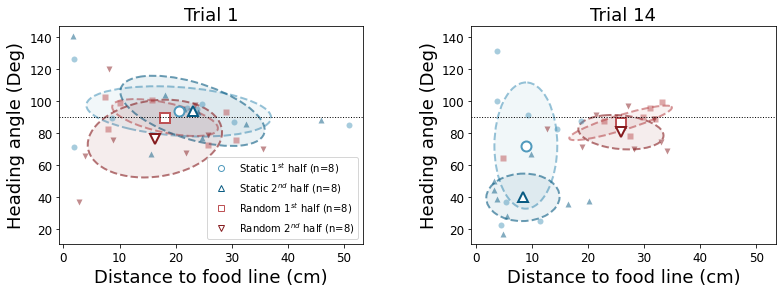

In [22]:
"""
###############
###############
###############
###############
############### heading angle vs.speed correlation
###############
###############
###############
###############
"""

set_y_logscale = False

all_trials_h1_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h1_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.0,dt_frac=0.5,copy_track=True)
all_trials_h2_rt = tran.slice_track_by_time_frac(all_trials_rt,t0_frac=0.5,dt_frac=0.5,copy_track=True)
all_trials_h2_ft = tran.slice_track_by_time_frac(all_trials_ft,t0_frac=0.5,dt_frac=0.5,copy_track=True)

# creating observation matrices
# rows -> trial
# cols -> observations of each trial
d_perp_h1_rt   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h1_rt ])
d_perp_h1_ft   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h1_ft ])
ha_mean_h1_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h1_rt ])
ha_mean_h1_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h1_ft ])
d_perp_h2_rt   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h2_rt ])
d_perp_h2_ft   = misc.asarray_nanfill([ misc.nanmean(misc.asarray_nanfill(tran.calc_mouse_perp_dist_to_food_line(all_mice,return_abs_value=True)),axis=1) for all_mice in all_trials_h2_ft ])
ha_mean_h2_rt  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h2_rt ])
ha_mean_h2_ft  = misc.asarray_nanfill([ misc.avg_angle_from_cos(misc.asarray_nanfill(tran.calc_mouse_deviation(all_mice,absolute_food_vec=False,return_angle=False)),axis=1)[0] for all_mice in all_trials_h2_ft ])


d_perp_h1_rt[ numpy.isnan( d_perp_h1_rt)]=0.0
d_perp_h1_ft[ numpy.isnan( d_perp_h1_ft)]=0.0
ha_mean_h1_rt[numpy.isnan(ha_mean_h1_rt)]=0.0
ha_mean_h1_ft[numpy.isnan(ha_mean_h1_ft)]=0.0
d_perp_h2_rt[ numpy.isnan( d_perp_h2_rt)]=0.0
d_perp_h2_ft[ numpy.isnan( d_perp_h2_ft)]=0.0
ha_mean_h2_rt[numpy.isnan(ha_mean_h2_rt)]=0.0
ha_mean_h2_ft[numpy.isnan(ha_mean_h2_ft)]=0.0


d_ha_cov_h1_rt = misc.calc_dispersion_rows(d_perp_h1_rt,ha_mean_h1_rt)
d_ha_cov_h1_ft = misc.calc_dispersion_rows(d_perp_h1_ft,ha_mean_h1_ft)
d_ha_cov_h2_rt = misc.calc_dispersion_rows(d_perp_h2_rt,ha_mean_h2_rt)
d_ha_cov_h2_ft = misc.calc_dispersion_rows(d_perp_h2_ft,ha_mean_h2_ft)

colors_rt = pltt.get_gradient(color='blue2')(numpy.linspace(0.5,1,n_trials))
colors_ft = pltt.get_gradient(color='red'  )(numpy.linspace(0.5,1,n_trials))


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),sharey=True,sharex=True)
ax[1].yaxis.set_tick_params(labelleft=True)


ax[0].plot(d_perp_h1_rt[0,:],ha_mean_h1_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[0].plot(d_perp_h1_ft[0,:],ha_mean_h1_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[0].plot(d_perp_h2_rt[0,:],ha_mean_h2_rt[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[0].plot(d_perp_h2_ft[0,:],ha_mean_h2_ft[0,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(d_ha_cov_h1_rt[0].r_mean,d_ha_cov_h1_rt[0].r_eigdir,d_ha_cov_h1_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_h1_ft[0].r_mean,d_ha_cov_h1_ft[0].r_eigdir,d_ha_cov_h1_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_h2_rt[0].r_mean,d_ha_cov_h2_rt[0].r_eigdir,d_ha_cov_h2_rt[0].r_dispersion,ax=ax[0],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(d_ha_cov_h2_ft[0].r_mean,d_ha_cov_h2_ft[0].r_eigdir,d_ha_cov_h2_ft[0].r_dispersion,ax=ax[0],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[0].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
pltt.plot_horizontal_lines(90,ax=ax[0],linestyle=':',color='k',linewidth=1)



ax[1].plot(d_perp_h1_rt[n_trials-1,:],ha_mean_h1_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='o',markerfacecolor=colors_rt[ 0], alpha=0.5, label='_Static (n=8)')
ax[1].plot(d_perp_h1_ft[n_trials-1,:],ha_mean_h1_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='s',markerfacecolor=colors_ft[ 0], alpha=0.5, label='_Random (n=8)')
ax[1].plot(d_perp_h2_rt[n_trials-1,:],ha_mean_h2_rt[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='^',markerfacecolor=colors_rt[-1], alpha=0.5, label='_Static (n=8)')
ax[1].plot(d_perp_h2_ft[n_trials-1,:],ha_mean_h2_ft[n_trials-1,:],linestyle='none',markersize=6,markeredgecolor='none',marker='v',markerfacecolor=colors_ft[-1], alpha=0.5, label='_Random (n=8)')
pltt.plot_dispersion(d_ha_cov_h1_rt[n_trials-1].r_mean,d_ha_cov_h1_rt[n_trials-1].r_eigdir,d_ha_cov_h1_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[ 0],0.6), marker='o', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_h1_ft[n_trials-1].r_mean,d_ha_cov_h1_ft[n_trials-1].r_eigdir,d_ha_cov_h1_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[ 0],0.6), marker='s', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[ 0],0.08) )
pltt.plot_dispersion(d_ha_cov_h2_rt[n_trials-1].r_mean,d_ha_cov_h2_rt[n_trials-1].r_eigdir,d_ha_cov_h2_rt[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_rt[-1],0.6), marker='^', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_rt[-1],0.08) )
pltt.plot_dispersion(d_ha_cov_h2_ft[n_trials-1].r_mean,d_ha_cov_h2_ft[n_trials-1].r_eigdir,d_ha_cov_h2_ft[n_trials-1].r_dispersion,ax=ax[1],color=numpy.append(colors_ft[-1],0.6), marker='v', linestyle='--', center_args=dict(alpha=1,markeredgewidth=2,markersize=10,markerfacecolor='w',fillstyle='full'),facecolor=numpy.append(colors_ft[-1],0.08) )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='o',markerfacecolor='w',color=colors_rt[ 0], label='Static 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='^',markerfacecolor='w',color=colors_rt[-1], label='Static 2$^{nd}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='s',markerfacecolor='w',color=colors_ft[ 0], label='Random 1$^{st}$ half (n=8)' )
ax[1].plot(numpy.nan,numpy.nan,linestyle='none',marker='v',markerfacecolor='w',color=colors_ft[-1], label='Random 2$^{nd}$ half (n=8)' )
pltt.plot_horizontal_lines(90,ax=ax[1],linestyle=':',color='k',linewidth=1)

set_y_logscale=False
ax[0].set_title( 'Trial 1'         ,fontsize=18)
ax[1].set_title(f'Trial {n_trials}',fontsize=18)
if set_y_logscale:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
pltt.set_xlabel(ax=ax,label='Distance to food line (cm)' ,fontsize=18)
pltt.set_ylabel(ax=ax,label='Heading angle (Deg)'         ,fontsize=18)
if set_y_logscale:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
else:
    ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0),   fontsize=10)
ax[1].set_position(numpy.array((ax[0].get_position().x1,0,0,0)) + ax[0].get_position().bounds  )


if save_output_figures:
    output_dir = 'figs/paper/dispersion_random_vs_static'
    fileName = f'{output_dir}/stat_vs_random_HALF_dispersion_headangle_d_perp.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()